# Xebra MC Calibration simulations

In [1]:
## Check Python version:
!python -V
!which root

Python 3.7.0


In [2]:
## Largest positive integer supported by the platform's Py_ssize_t type:
import sys
sys.maxsize

9223372036854775807

## Imports and function definitions

In [3]:
## Imports:

import numpy as np
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
from matplotlib import gridspec            # to arrange the plots nicely
%matplotlib inline

import uproot                              # uproot for easy import of ROOT tree contents
import collections                         # used for named tuples
import pandas as pd
from scipy.optimize import curve_fit

In [4]:
## Function definitions:

def flatten_tuples(tup):
    return np.array([element for tupl in tup for element in tupl])

def sum_tuple_subentries(tup):
    return [np.sum(tupl) for tupl in tup]

def nth_tuple_subentries(tup, n):
    return [tupl[n] for tupl in tup]

In [5]:
## Available ROOT files in specified folder:
! ls ../../Xebra_G4/*.root
#! ls ../../Analysis/Calibration_simulations_pointsource/data/*.root
! ls ../../Simulation_Data/Calibration_simulations_pointsource/*.root
! ls ../../Simulation_Data/Calibration_simulations_pointsource/proc/*.root

ls: cannot access '../../Xebra_G4/*.root': No such file or directory
../../Simulation_Data/Calibration_simulations_pointsource/Cs137_1e5_noscint.root
../../Simulation_Data/Calibration_simulations_pointsource/Cs137_1e5_scint.root
../../Simulation_Data/Calibration_simulations_pointsource/Cs137_1e6_noscint_inside.root
../../Simulation_Data/Calibration_simulations_pointsource/Cs137_1e7_noscint.root
../../Simulation_Data/Calibration_simulations_pointsource/Cs137_1e8_noscint.root
../../Simulation_Data/Calibration_simulations_pointsource/proc/Cs137_1e6_noscint_inside_z3mm_MS_Sorted.root
../../Simulation_Data/Calibration_simulations_pointsource/proc/Cs137_1e6_noscint_inside_z3mm_SS_Sorted.root
../../Simulation_Data/Calibration_simulations_pointsource/proc/Cs137_1e8_noscint_z3mm_MS_Sorted.root
../../Simulation_Data/Calibration_simulations_pointsource/proc/Cs137_1e8_noscint_z3mm_SS_Sorted.root


In [6]:
! ls -sh ../../Simulation_Data/Calibration_simulations_pointsource/*.root
! ls -sh ../../Simulation_Data/Calibration_simulations_pointsource/proc/*.root

1,2M ../../Simulation_Data/Calibration_simulations_pointsource/Cs137_1e5_noscint.root
1,4M ../../Simulation_Data/Calibration_simulations_pointsource/Cs137_1e5_scint.root
124M ../../Simulation_Data/Calibration_simulations_pointsource/Cs137_1e6_noscint_inside.root
 87M ../../Simulation_Data/Calibration_simulations_pointsource/Cs137_1e7_noscint.root
853M ../../Simulation_Data/Calibration_simulations_pointsource/Cs137_1e8_noscint.root
2,3M ../../Simulation_Data/Calibration_simulations_pointsource/proc/Cs137_1e6_noscint_inside_z3mm_MS_Sorted.root
1,5M ../../Simulation_Data/Calibration_simulations_pointsource/proc/Cs137_1e6_noscint_inside_z3mm_SS_Sorted.root
 16M ../../Simulation_Data/Calibration_simulations_pointsource/proc/Cs137_1e8_noscint_z3mm_MS_Sorted.root
9,6M ../../Simulation_Data/Calibration_simulations_pointsource/proc/Cs137_1e8_noscint_z3mm_SS_Sorted.root


In [7]:
## Selection of file to be analyzed:
#filename = '../../Simulation_Data/Calibration_simulations_pointsource/Cs137_1e6_noscint_inside.root'
#filename = '../../Simulation_Data/Calibration_simulations_pointsource/Cs137_1e8_noscint.root'
filename = '../../Simulation_Data/Calibration_simulations_pointsource/proc/Cs137_1e8_noscint_z3mm_MS_Sorted.root'
#filename = '../../Simulation_Data/Calibration_simulations_pointsource/proc/Cs137_1e6_noscint_inside_z3mm_SS_Sorted.root'

In [8]:
# adjust:
full_absorption = False

In [9]:
# filename prefix for automatically naming outputs

Clustered = False

if filename[6:14] == 'Xebra_G4':
    filenameprefix = filename[:-5][15:]
    
elif filename[6:57] == 'Simulation_Data/Calibration_simulations_pointsource':
    
    if filename[58:62] == 'proc':
        filenameprefix = filename[:-5][63:]
        Clustered = True
    else:
        filenameprefix = filename[:-5][58:]

else:
    filenameprefix = 'filenameprefix'
    
print(filenameprefix)
print('Clustered:       '+str(Clustered))
print('Full Absorption: '+str(full_absorption))

Cs137_1e8_noscint_z3mm_MS_Sorted
Clustered:       True
Full Absorption: False


## Extraction and processing of input data

In [10]:
## Inspect branches:

if Clustered == True:
    f = uproot.open(filename)['events']
    eventid = f['EventId'].array()
    f.keys()
    print(f.keys())

else:
    f = uproot.open(filename)['events/events']
    eventid = f['eventid'].array()
    f.keys()
    print(f.keys())

[b'EventId', b'n_steps', b'Xp', b'Yp', b'Zp', b'xpri', b'ypri', b'zpri', b'epri', b'Etot', b'typepri']


In [11]:
'''## Determine number of events in all files:
MC_files = [filename]
nevents = [_chunk[1] for _chunk in uproot.iterate(MC_files, "events/events", ["?"], reportentries=True, entrysteps=10000000, outputtype=collections.namedtuple)][-1]
print(nevents)''';

In [12]:
'''## Iterate TChain like over branches of several ROOT files with N events per step

MC_files = [filename]
N = nevents

for xp_pri, yp_pri, zp_pri in uproot.iterate(MC_files, "events/events", ["xp_pri", "yp_pri", "zp_pri"], entrysteps=N, outputtype=tuple):
    print(len(xp_pri), end=' ')
    break
    
for xp, yp, zp in uproot.iterate(MC_files, "events/events", ["xp", "yp", "zp"], entrysteps=N, outputtype=tuple):
    print(len(xp), end=' ')
    break''';

In [13]:
'''## Iterate TChain like with all possible branches in a single collection:

MC_files = [filename]
N = nevents

for _chunk in uproot.iterate(MC_files, "events/events", ["*"], entrysteps=N, outputtype=collections.namedtuple):
    break''';

In [14]:
'''## Save relevant entries:

xp_pri = _chunk.xp_pri
yp_pri = _chunk.yp_pri
zp_pri = _chunk.zp_pri
xp = _chunk.xp
yp = _chunk.yp
zp = _chunk.zp
etot = _chunk.etot
ed = _chunk.ed
nsteps = _chunk.nsteps

print(len(xp))''';

In [15]:
## Import as panda dataframes

if Clustered == True:
    
    branches= ['xpri','ypri','zpri','Xp','Yp','Zp','Etot'] # Be careful that the branches are also initilized in _chunk_collect

    import concurrent.futures
    executor = concurrent.futures.ThreadPoolExecutor(8)

    _chunk_collect = pd.DataFrame({'xpri' : [],'ypri' : [],'zpri' : [], 'Xp' : [],'Yp' : [],'Zp' : [],'Etot' : []}) # Initialize empty data frame

    for _chunk in uproot.iterate(filename, "events",branches, entrysteps=100000, 
                                           outputtype=pd.DataFrame, executor=executor):
        _chunk.columns=branches
        _chunk_collect = _chunk_collect.append(_chunk)    
        
    _chunk_collect = _chunk_collect.rename(index=str, columns={"xpri": "xp_pri", "ypri": "yp_pri", "zpri": "zp_pri", "Xp": "xp", "Yp": "yp", "Zp": "zp", "Etot": "ed"})
    
else:

    branches= ['xp_pri','yp_pri','zp_pri','xp','yp','zp','etot','ed','nsteps'] # Be careful that the branches are also initilized in _chunk_collect

    import concurrent.futures
    executor = concurrent.futures.ThreadPoolExecutor(8)

    _chunk_collect = pd.DataFrame({'xp_pri' : [],'yp_pri' : [],'zp_pri' : [], 'xp' : [],'yp' : [],'zp' : [],'etot' : [],'ed' : [],'nsteps' : []}) # Initialize empty data frame

    for _chunk in uproot.iterate(filename, "events/events",branches, entrysteps=100000, 
                                           outputtype=pd.DataFrame, executor=executor):
        _chunk.columns=branches
        #_chunk =_chunk[ _chunk['ed'].apply(lambda x: len(x)==1) ] # Remove events with more than one scatter
        #_chunk =_chunk.applymap(lambda x: x[0]) # Convert lists in cells by taking only the 0th element
        #_chunk.type_pri =_chunk.type_pri.apply(lambda x: x.decode("utf-8")) # Decode bytestrings for primary type
        _chunk_collect = _chunk_collect.append(_chunk)

#print(_chunk.tail(10))
#_chunk_collect.tail(10)
#_chunk_collect.head(10)
#_chunk_collect

/home/ab602/anaconda3/lib/python3.7/site-packages/uproot/tree.py:116: FutureWarning: Int64Index.data is deprecated and will be removed in a future version
  index = awkward.numpy.frombuffer(arrays.index.data, dtype=arrays.index.dtype)


In [16]:
margin = 1

if full_absorption == True:
    filenameprefix = filenameprefix+'_fullAbsorption'
    _chunk_collect = _chunk_collect.loc[(_chunk_collect["ed"] > (661.7 - margin) )]
    
filenameprefix

'Cs137_1e8_noscint_z3mm_MS_Sorted'

In [17]:
_chunk_collect

,xp_pri,yp_pri,zp_pri,xp,yp,zp,ed
0,0.0,-122.0,-35.75,10.406030,-14.779400,-66.607697,10.671613
1,0.0,-122.0,-35.75,14.133690,1.527914,-60.521130,416.494415
2,0.0,-122.0,-35.75,13.257442,-26.586338,-30.797083,304.067993
3,0.0,-122.0,-35.75,16.768539,-13.021190,-25.083603,331.792633
4,0.0,-122.0,-35.75,-11.689124,-10.326403,-57.557659,166.101852
5,0.0,-122.0,-35.75,-12.568006,-6.727787,-54.036812,440.265411
6,0.0,-122.0,-35.75,-11.797257,-22.710503,-33.732681,41.342449
7,0.0,-122.0,-35.75,-24.912861,17.049559,-25.885920,164.639648
8,0.0,-122.0,-35.75,20.729452,-25.458328,-66.868927,289.853912
9,0.0,-122.0,-35.75,3.240505,-19.482933,-60.691917,661.657288


In [18]:
## Process data:

nevents = len(_chunk_collect.xp_pri)
print('nevents: '+str(nevents))

if Clustered == True:
    xp_flat = _chunk_collect.xp
    yp_flat = _chunk_collect.yp
    zp_flat = _chunk_collect.zp
    rp_flat = np.sqrt(xp_flat * xp_flat + yp_flat * yp_flat)
    ed_flat = _chunk_collect.ed
    
else:
    xp_flat = flatten_tuples(_chunk_collect.xp)
    yp_flat = flatten_tuples(_chunk_collect.yp)
    zp_flat = flatten_tuples(_chunk_collect.zp)
    rp_flat = np.sqrt(xp_flat * xp_flat + yp_flat * yp_flat)
    ed_flat = flatten_tuples(_chunk_collect.ed)

    print('nevents_flat: '+str(len(xp_flat)))

nevents: 711586


In [19]:
'''## Deletion for storage reduction

try:
    del _chunk
    print("Deleted _chunk")
except NameError:
    print("Deleted _chunk (already done)")
    
try:
    del _chunk_collect
    print("Deleted _chunk_collect")
except NameError:
    print("Deleted _chunk_collect (already done)")''';

## Analysis

### Energy spectrum

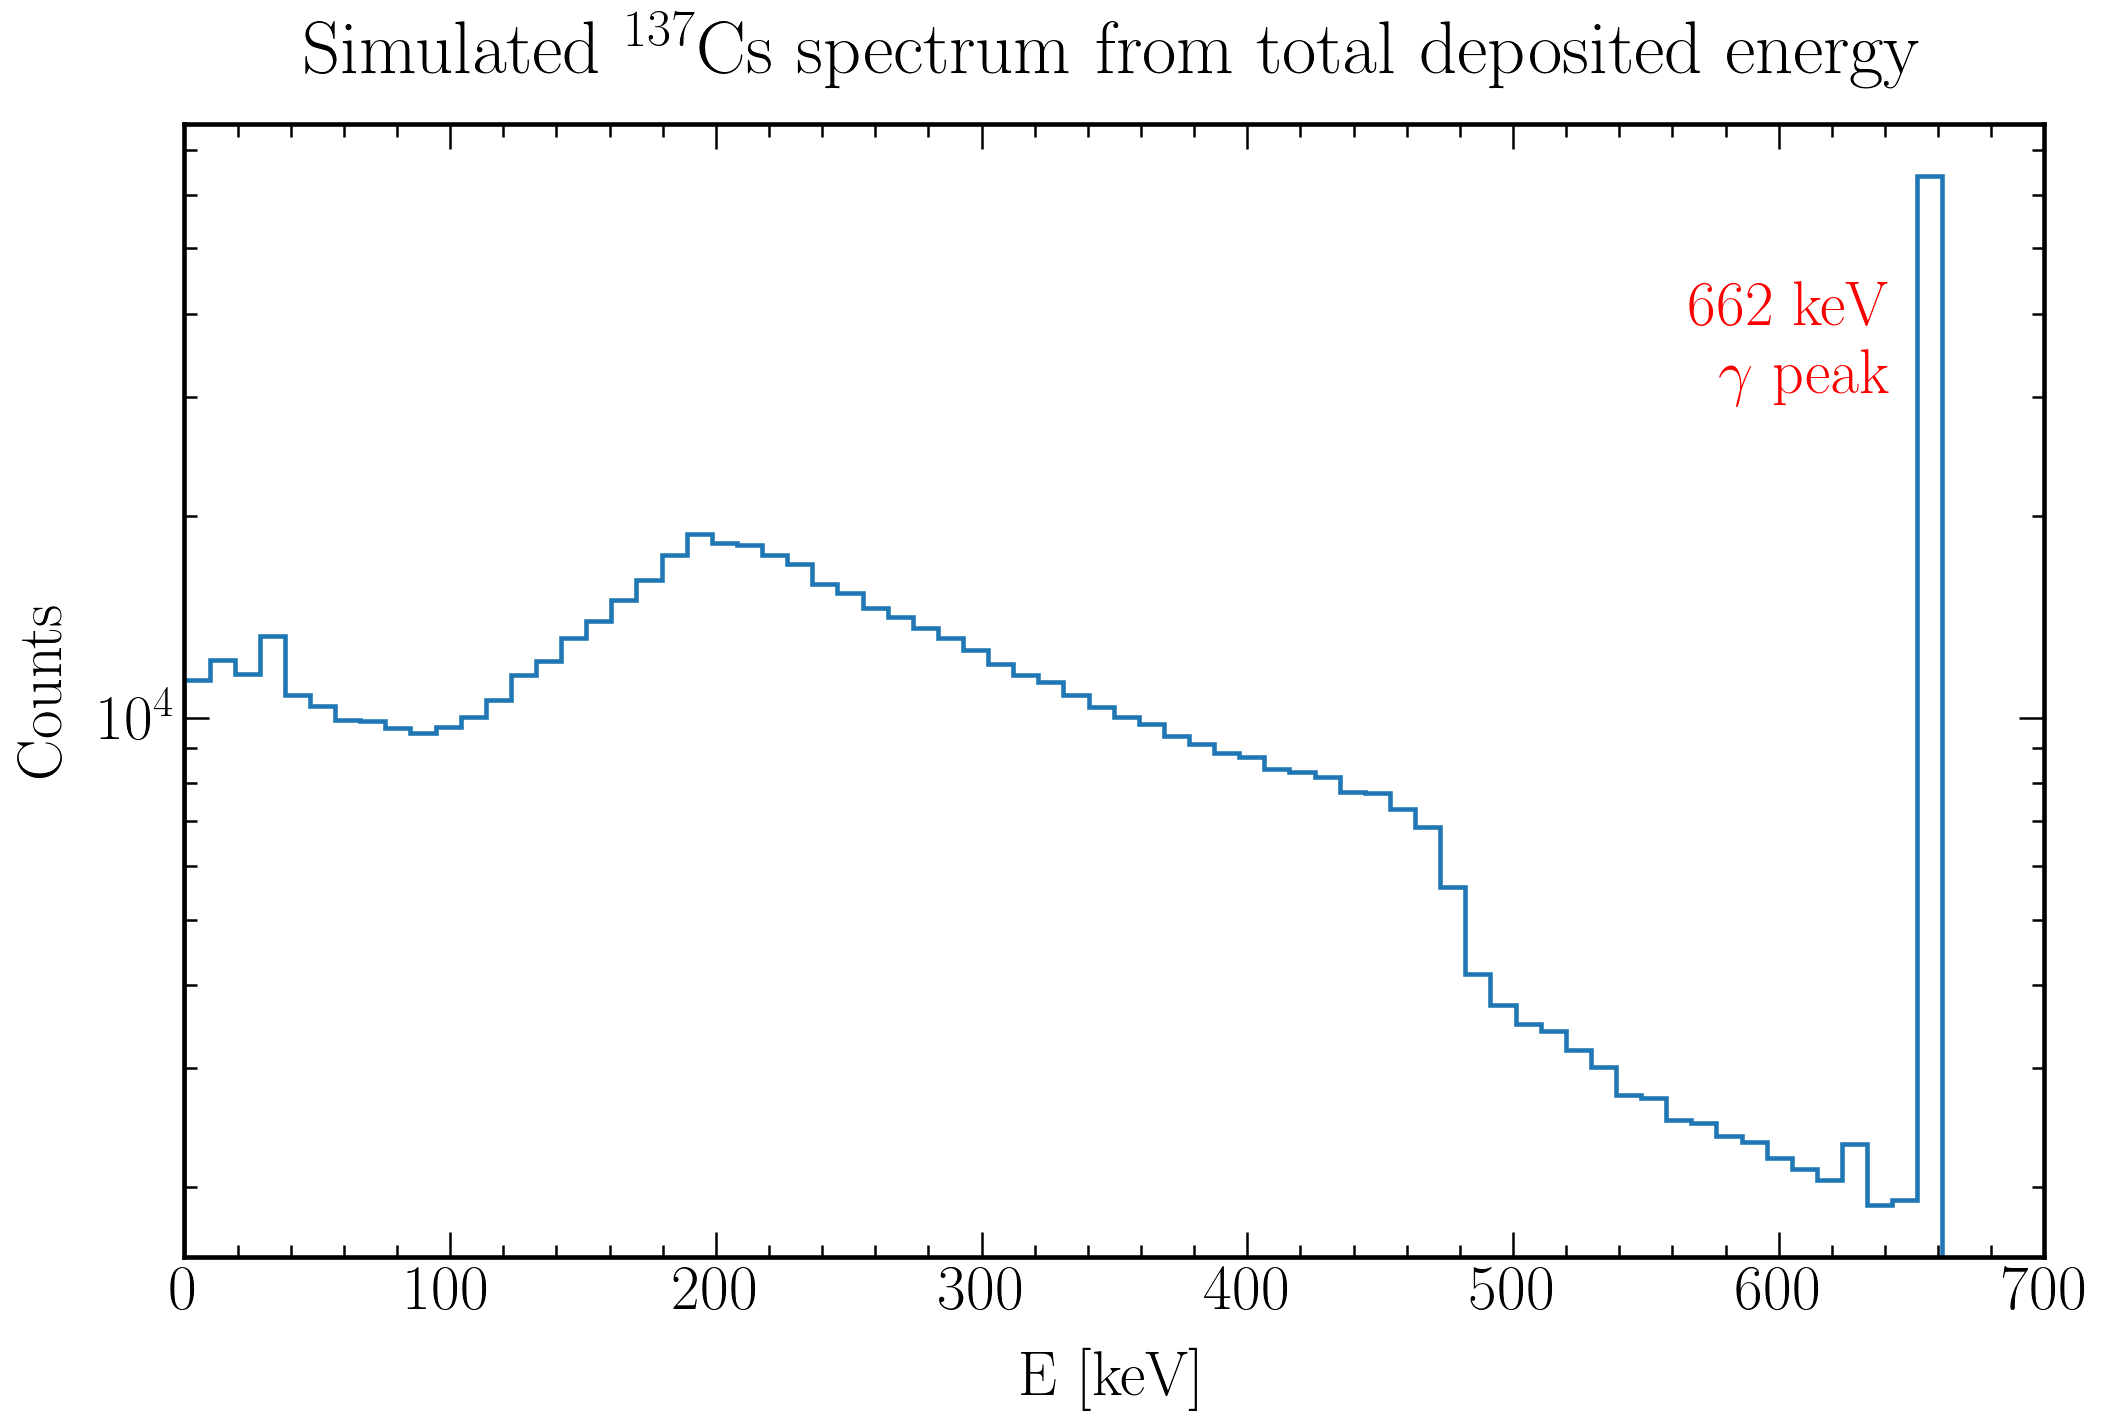

In [20]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
if Clustered == True:
    n, bins, patches = plt.hist(_chunk_collect.ed, 70, facecolor='darkblue', histtype = 'step', linewidth = 2.2)
else:
    n, bins, patches = plt.hist(_chunk_collect.etot, 70, facecolor='darkblue', histtype = 'step', linewidth = 2.2)

plt.xlabel('E [keV]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Simulated $^{137}$Cs spectrum from total deposited energy', fontsize = title_size, pad = title_pad)

# Axes ---> Shading an area or Drawing a vertica line
#axes.axvspan(662-10, 662+10, alpha=0.5, color='0.8')
#plt.axvline(662, alpha=0.5, color='grey')

plt.text(662-10-10, 0.7*int(max(n)), "662 keV\n$\gamma$ peak", fontsize = label_size, horizontalalignment='right', verticalalignment='top', multialignment='right', color = 'red')

# Axes ---> Range
plt.xlim(0,700)
#plt.ylim(0,16000)
#plt.xlim(left=0)
'''plt.ylim(bottom=2500)
plt.ylim(top=150000)'''
plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_totalenergy_spectrum.png")

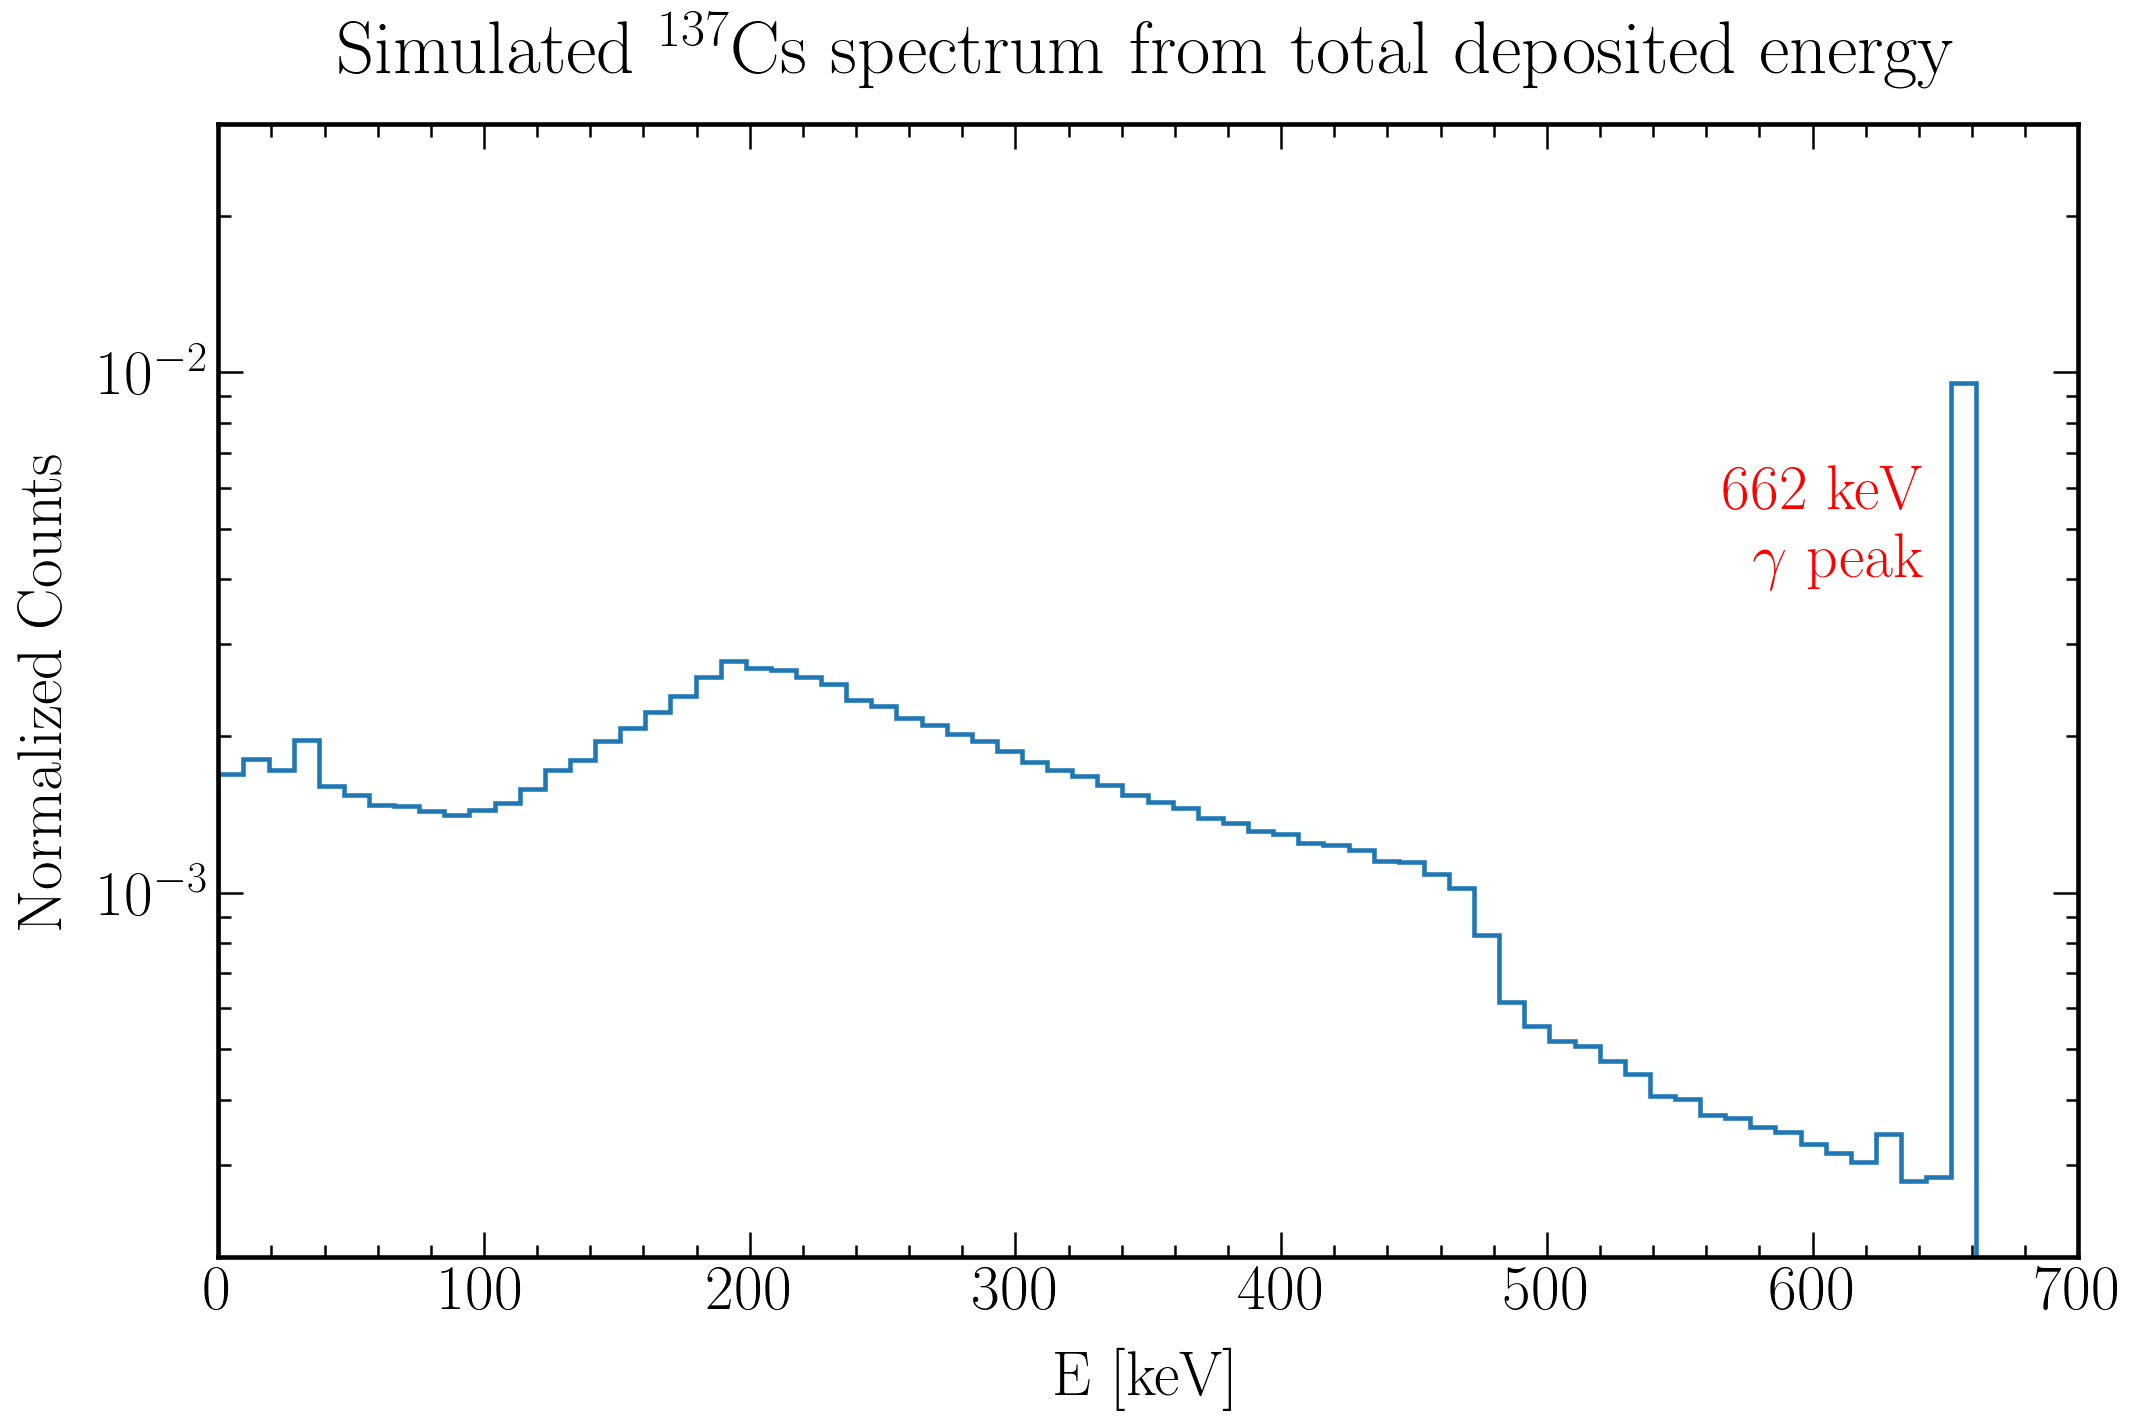

In [21]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
if Clustered == True:
    n, bins, patches = plt.hist(_chunk_collect.ed, 70, facecolor='darkblue', histtype = 'step', linewidth = 2.2, density = True)
else:
    n, bins, patches = plt.hist(_chunk_collect.etot, 70, facecolor='darkblue', histtype = 'step', linewidth = 2.2, density = True)

plt.xlabel('E [keV]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Normalized Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Simulated $^{137}$Cs spectrum from total deposited energy', fontsize = title_size, pad = title_pad)

# Axes ---> Shading an area or Drawing a vertica line
#axes.axvspan(662-10, 662+10, alpha=0.5, color='0.8')
#plt.axvline(662, alpha=0.5, color='grey')

plt.text(662-10-10, 0.7*max(n), "662 keV\n$\gamma$ peak", fontsize = label_size, horizontalalignment='right', verticalalignment='top', multialignment='right', color = 'red')

# Axes ---> Range
plt.xlim(0,700)
plt.ylim(2e-4,3e-2)
#plt.xlim(left=0)
'''plt.ylim(bottom=2500)
plt.ylim(top=150000)'''
plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_totalenergy_spectrum_normed.png")

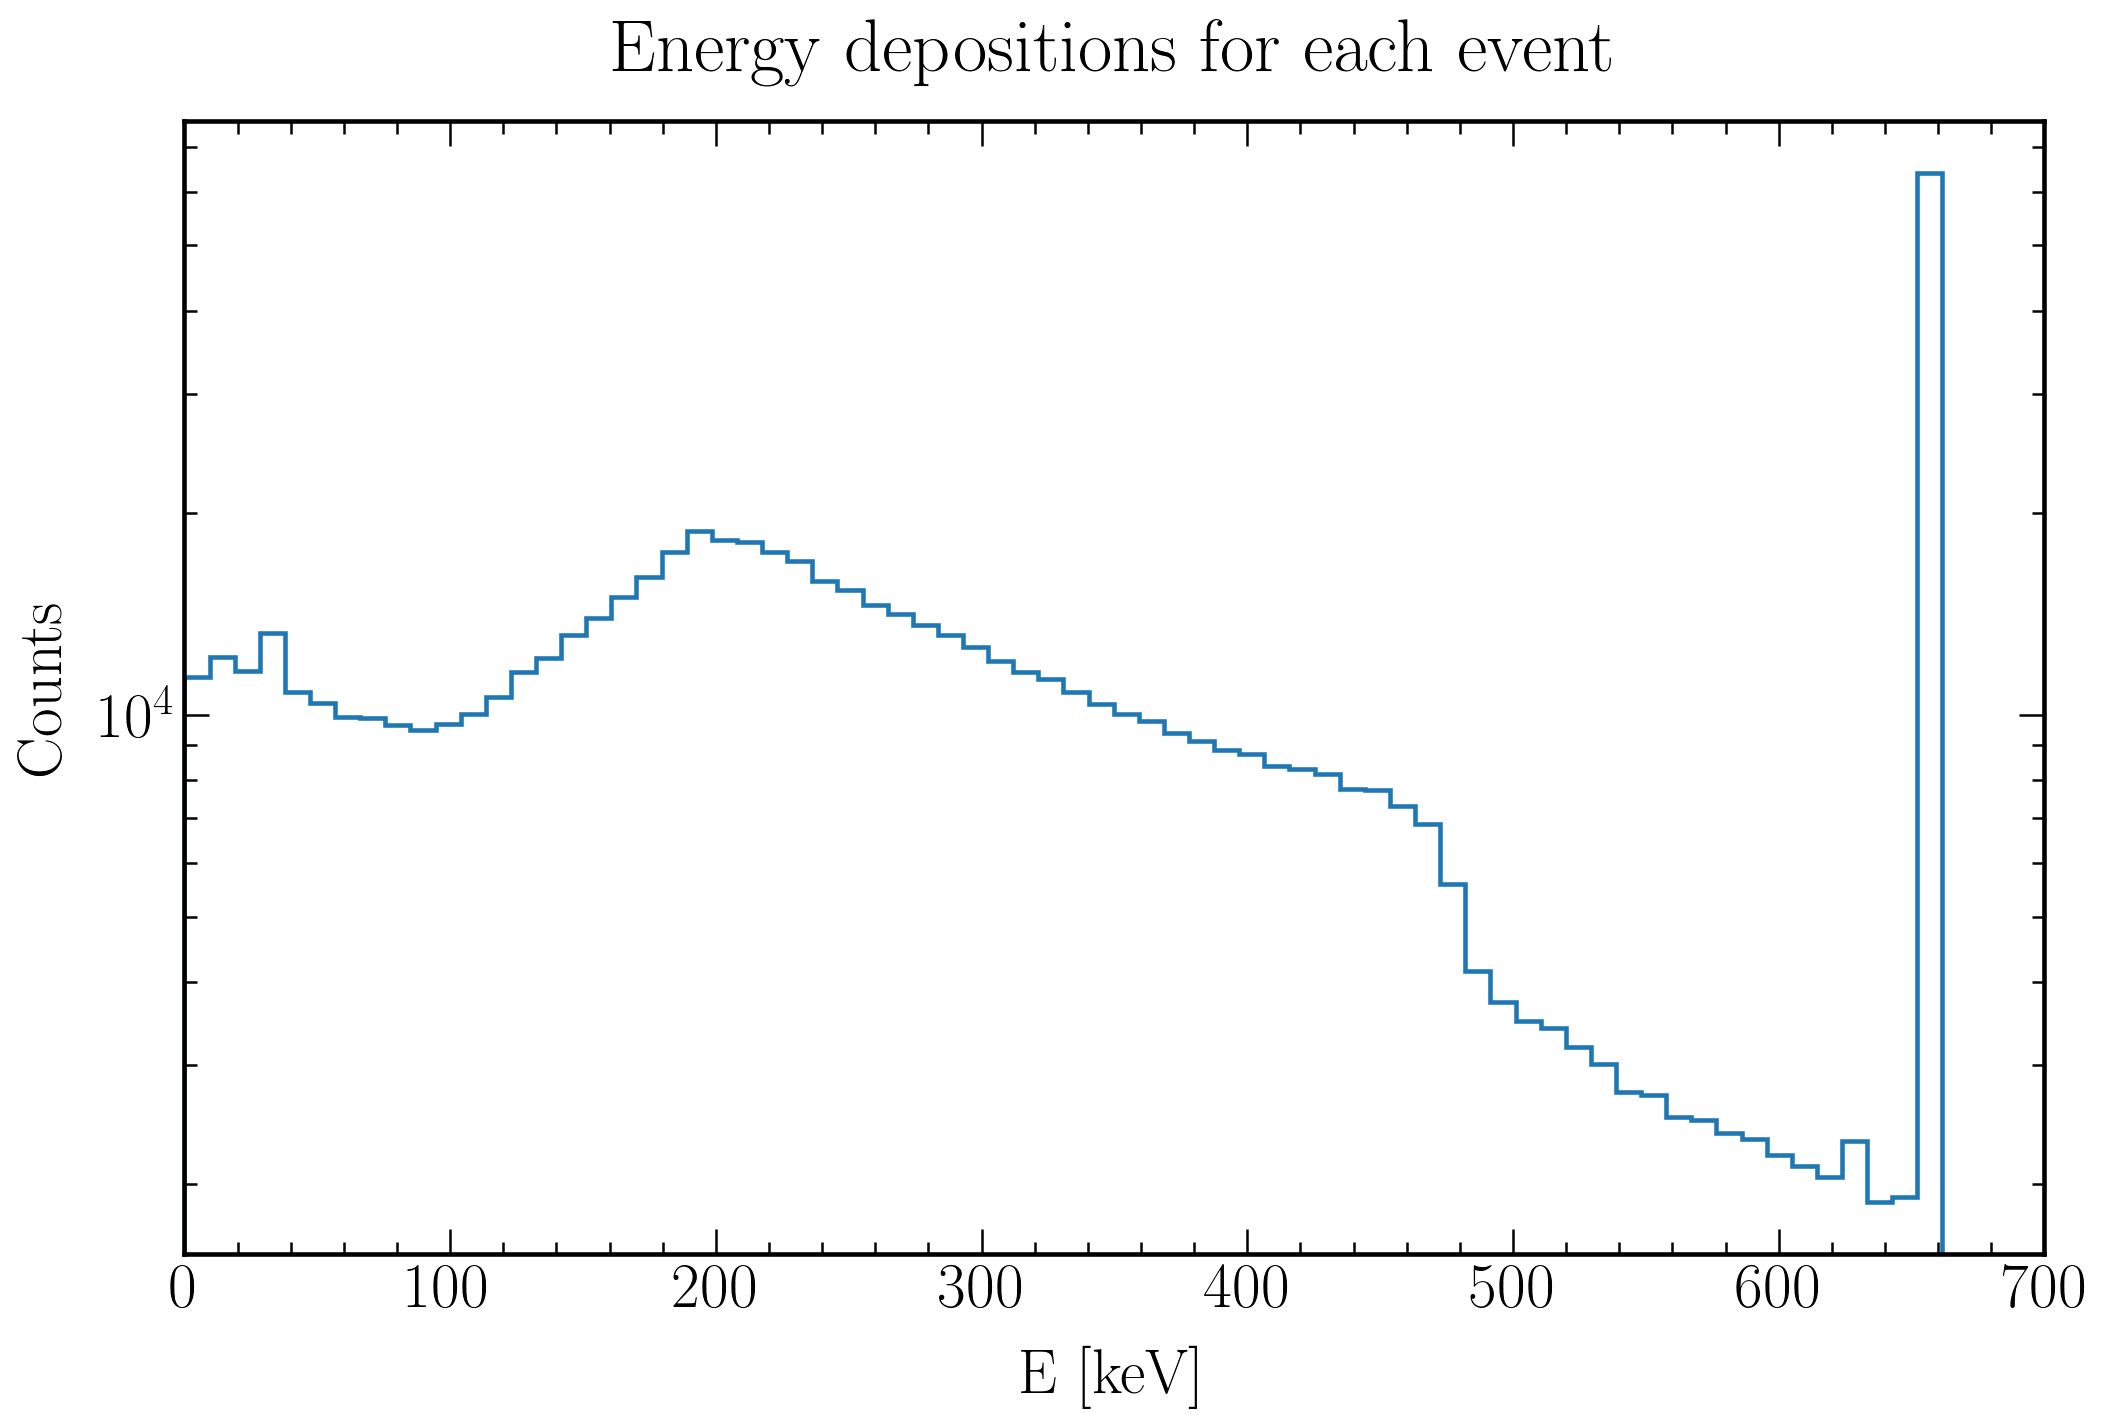

In [22]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
n, bins, patches = plt.hist(ed_flat, 70, facecolor='darkblue', histtype = 'step', linewidth = 2.2)

plt.xlabel('E [keV]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Energy depositions for each event', fontsize = title_size, pad = title_pad)

# Axes ---> Range
plt.xlim(0,700)
#plt.ylim(0,16000)
#plt.xlim(left=0)
plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_ed_spectrum.png")

### Event positions

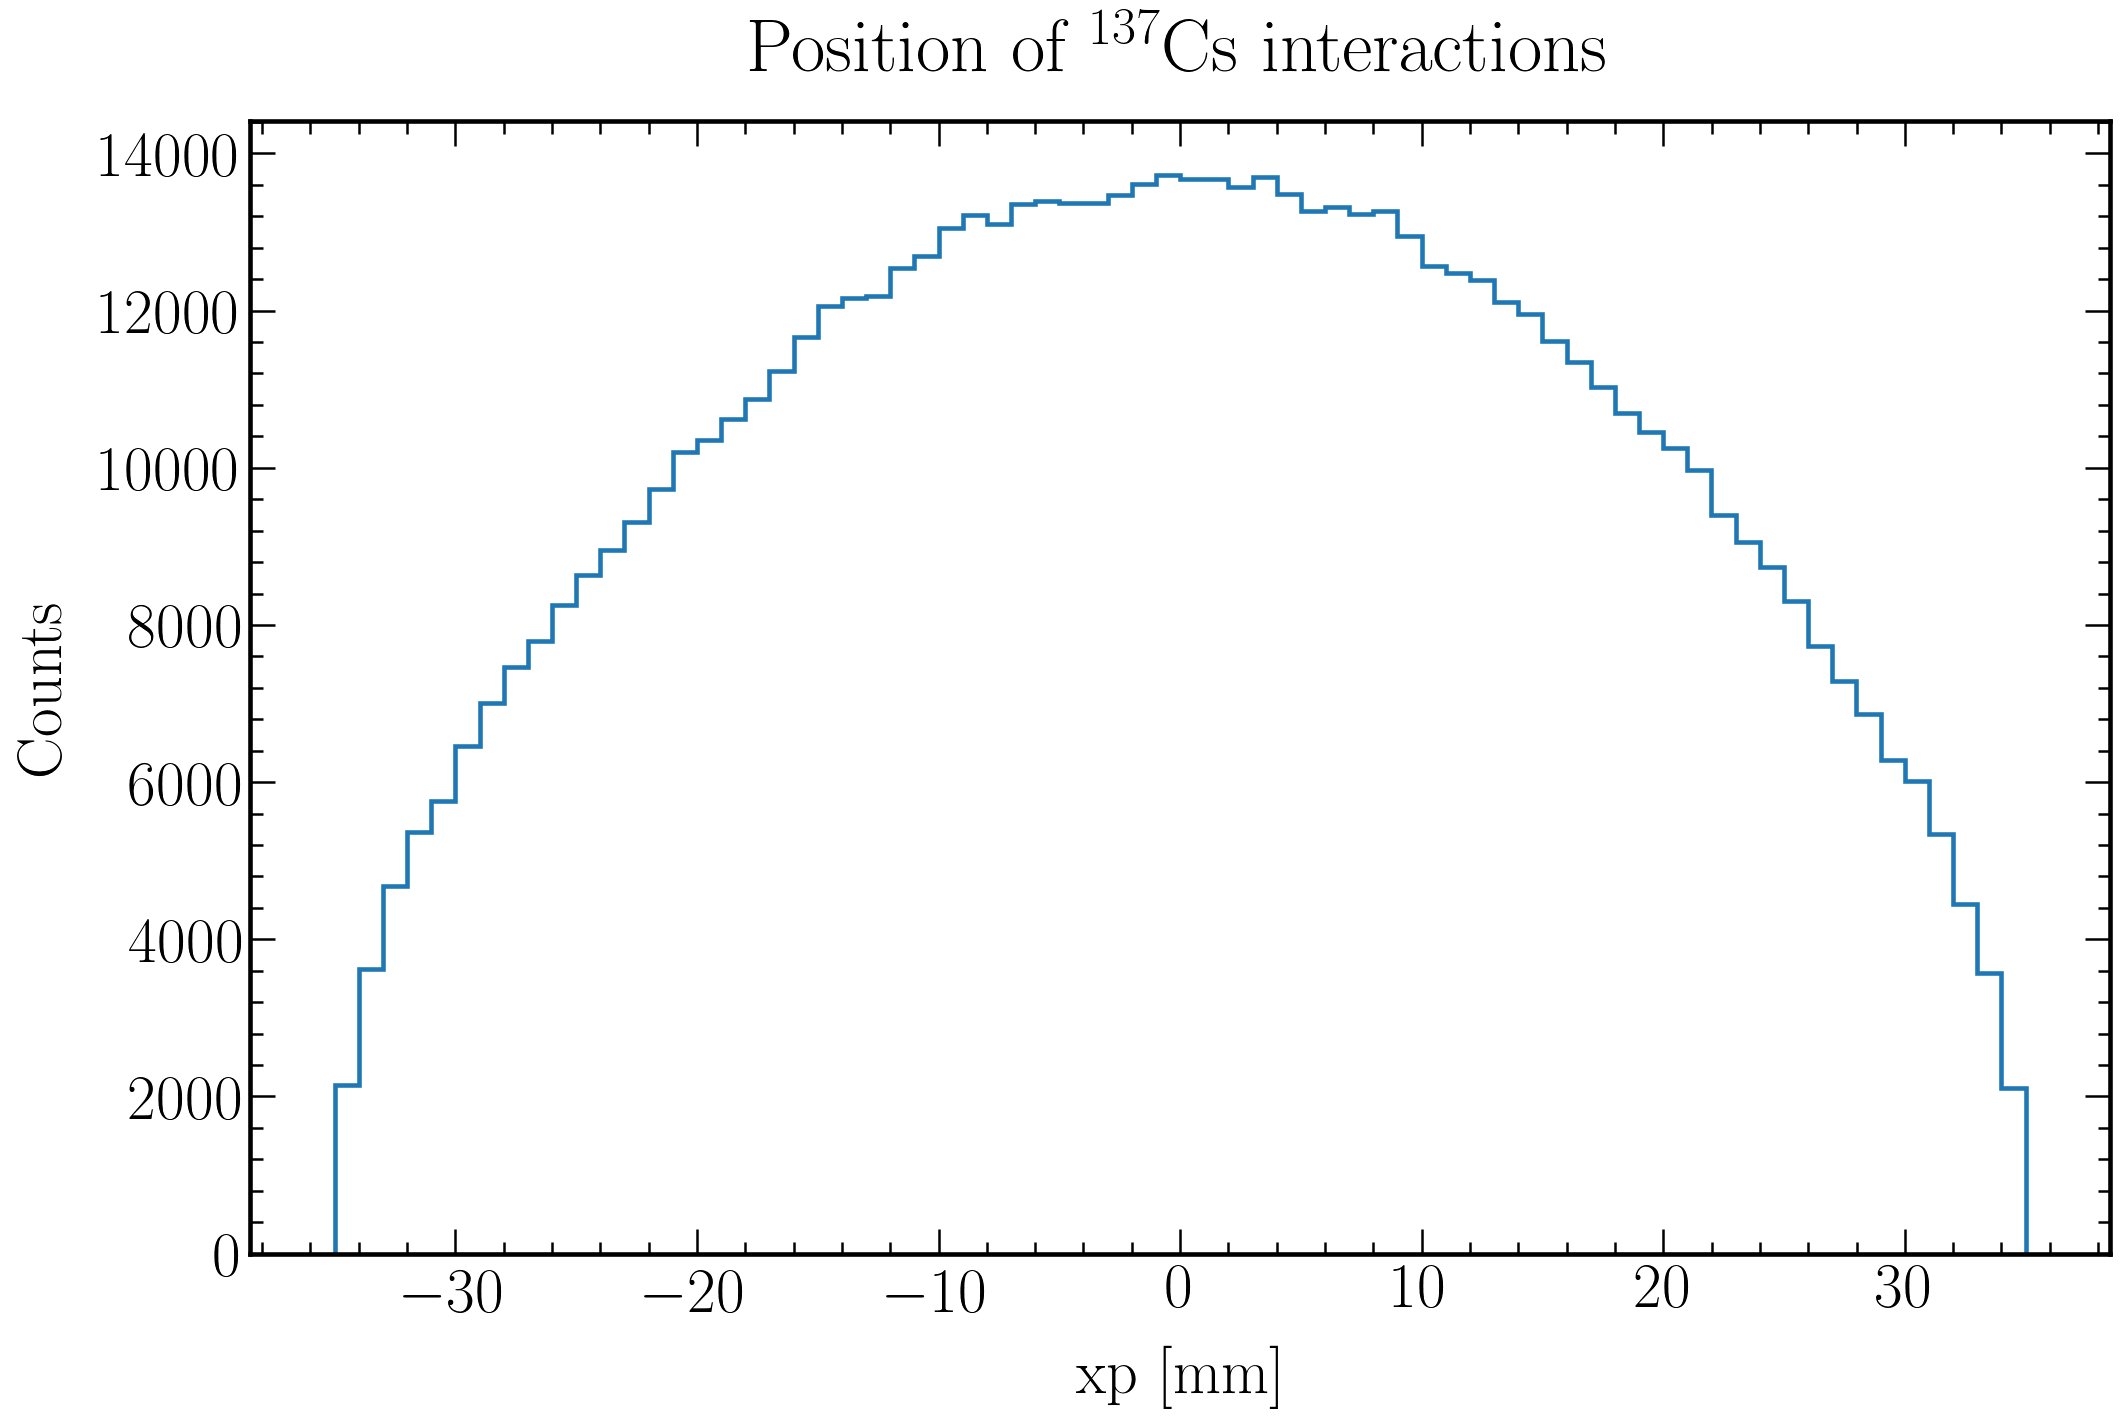

In [23]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
n, bins, patches = plt.hist(xp_flat, 70, facecolor='darkblue', histtype = 'step', linewidth = 2.2)

plt.xlabel('xp [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Position of $^{137}$Cs interactions', fontsize = title_size, pad = title_pad)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_xp_spectrum.png")

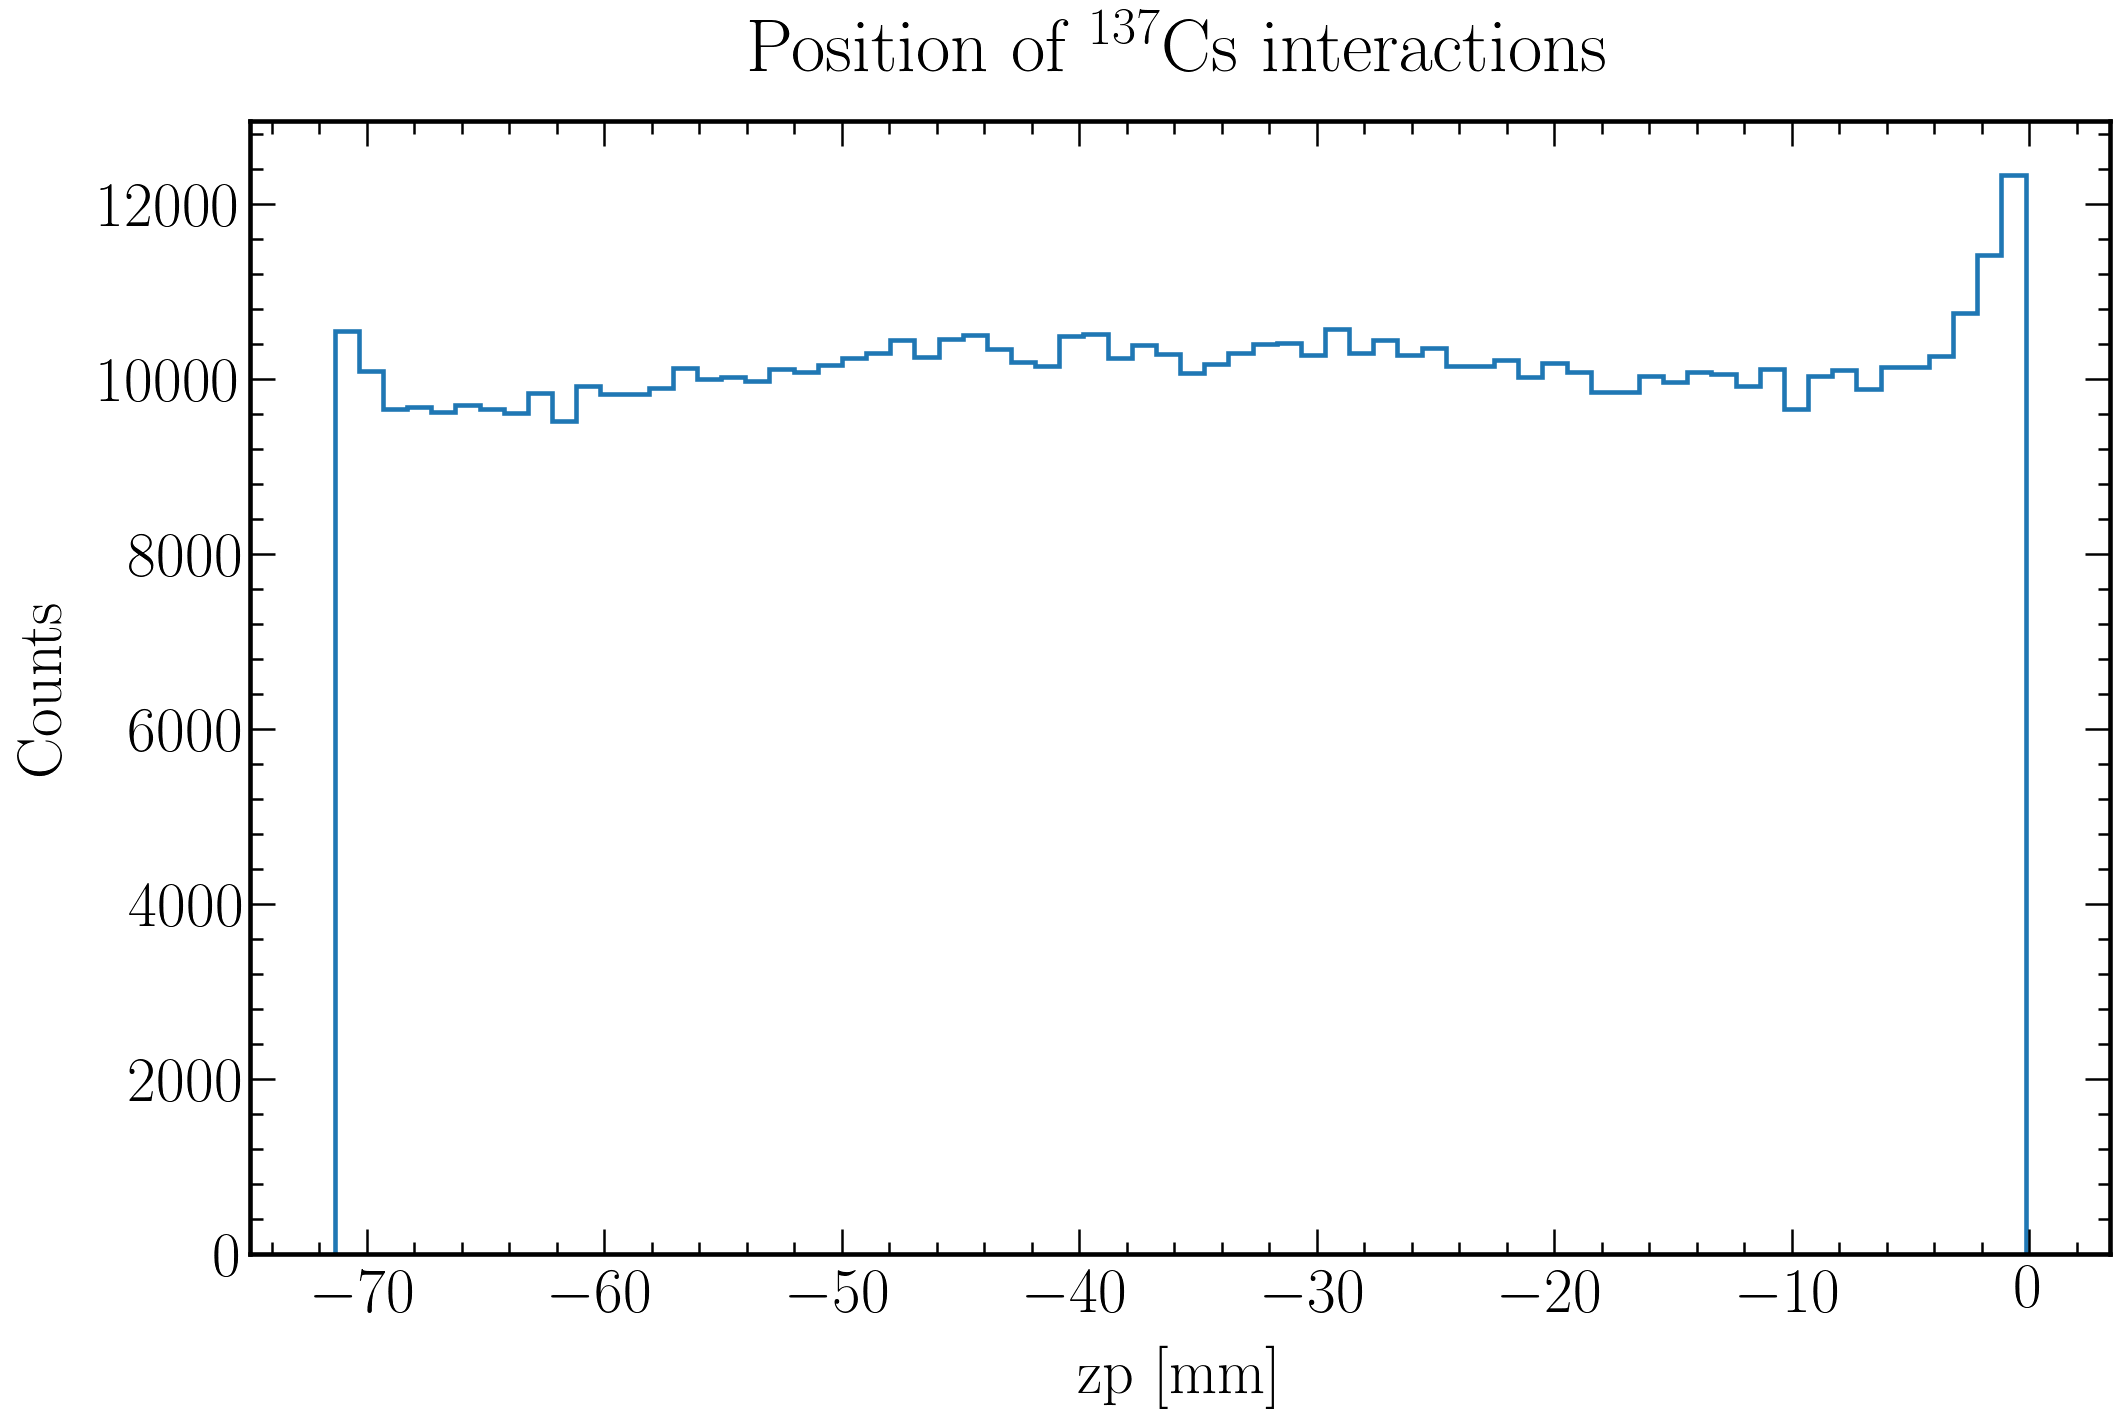

In [24]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
n, bins, patches = plt.hist(zp_flat, 70, facecolor='darkblue', histtype = 'step', linewidth = 2.2)

plt.xlabel('zp [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Position of $^{137}$Cs interactions', fontsize = title_size, pad = title_pad)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_zp_spectrum.png")

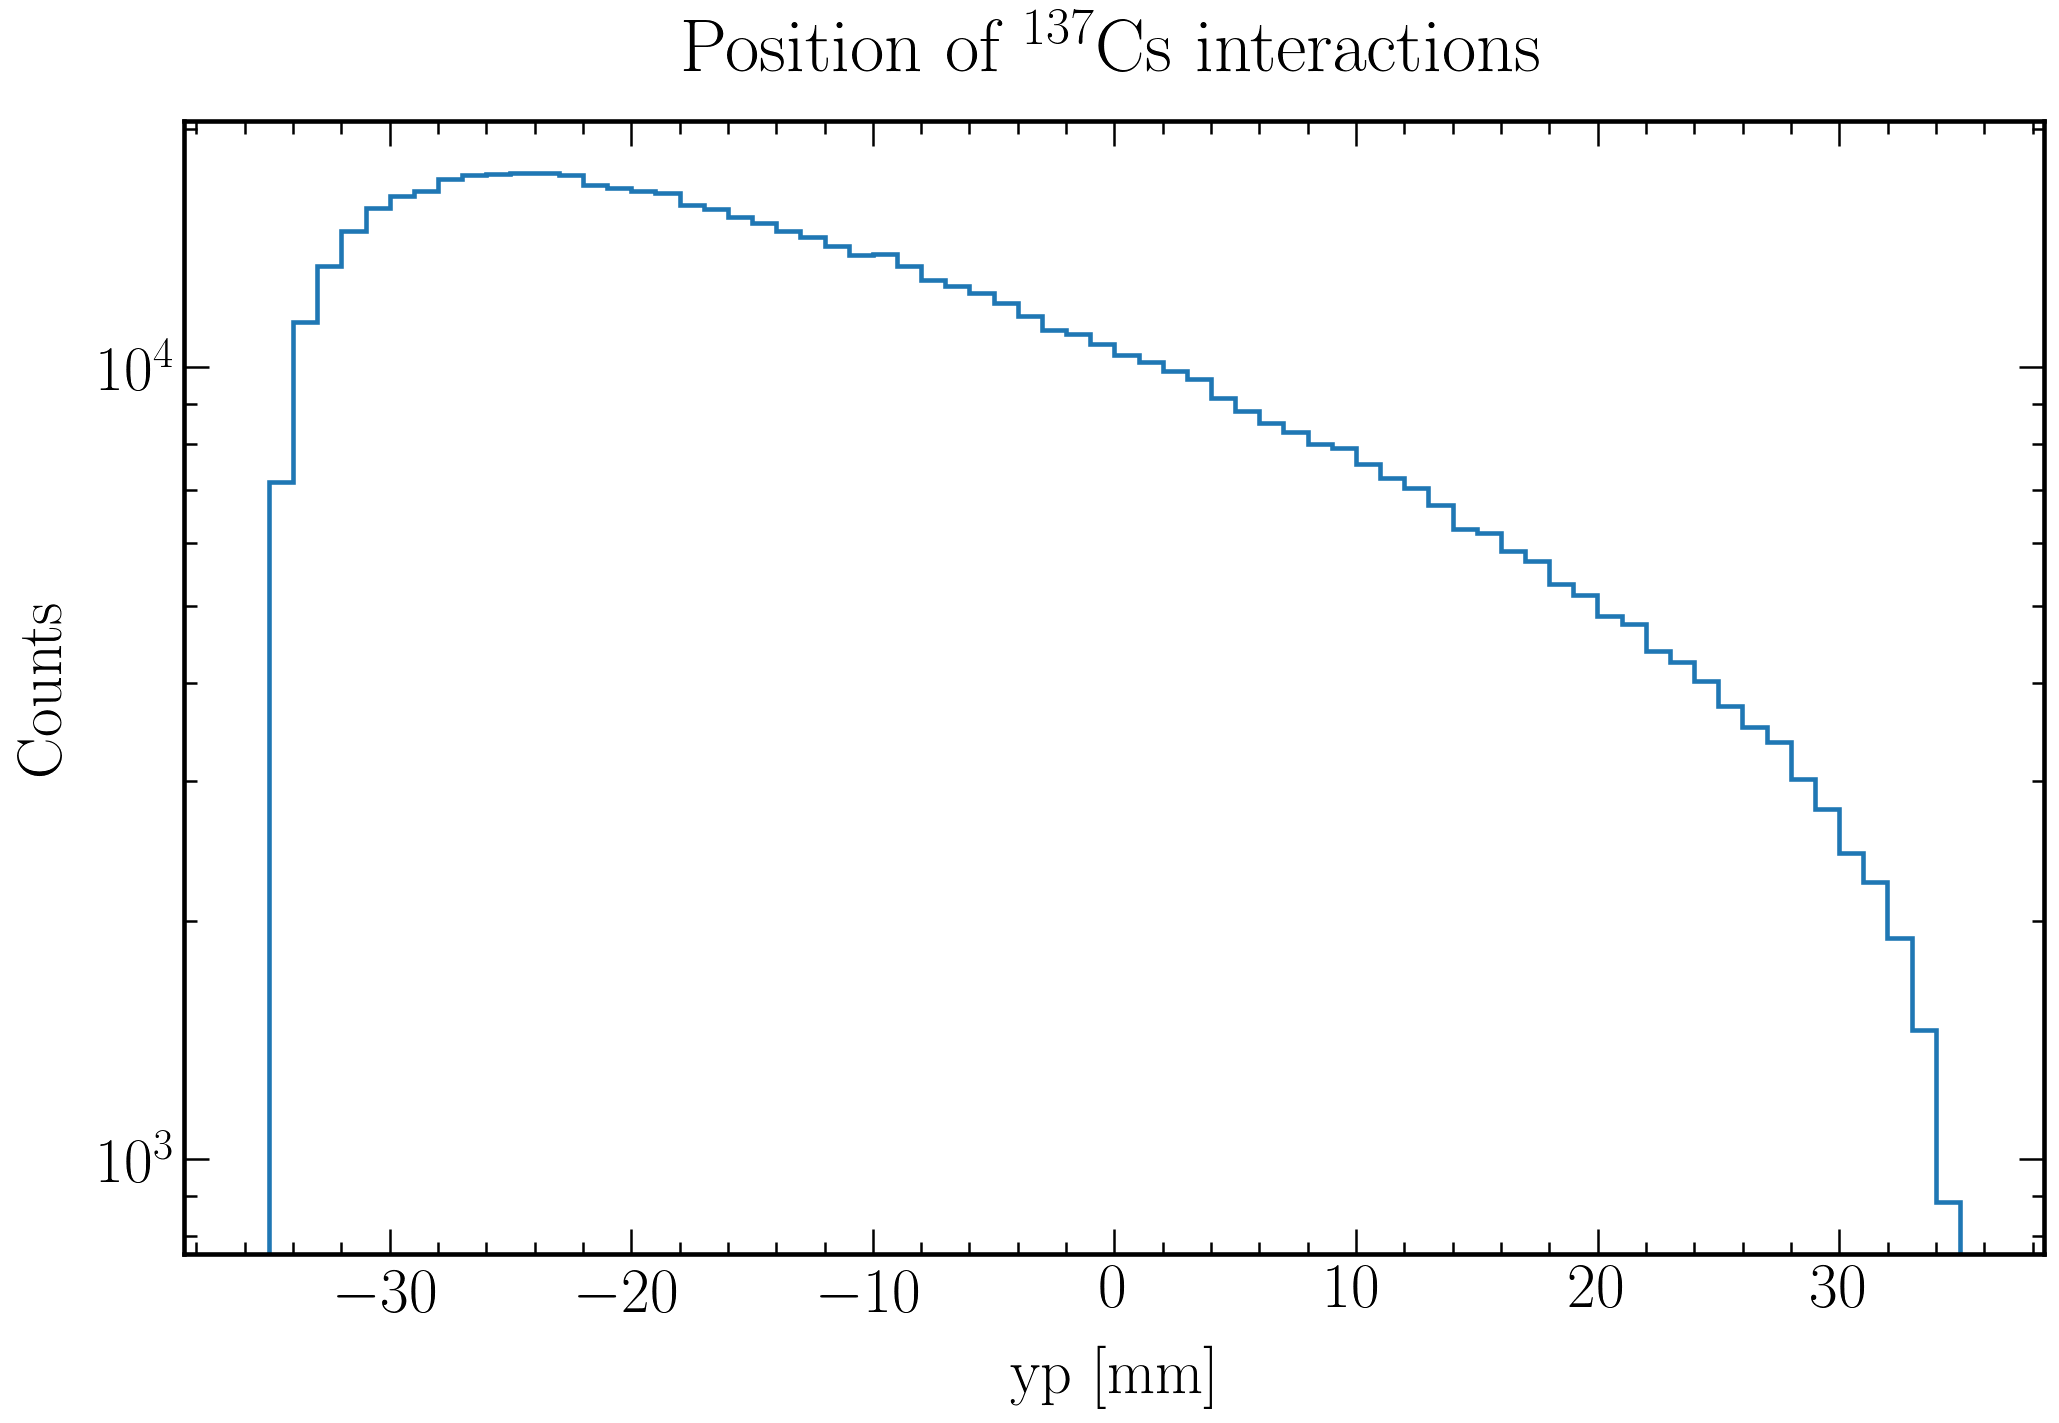

In [25]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
n, bins, patches = plt.hist(yp_flat, 70, facecolor='darkblue', histtype = 'step', linewidth = 2.2)

plt.xlabel('yp [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Position of $^{137}$Cs interactions', fontsize = title_size, pad = title_pad)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_yp_spectrum.png")

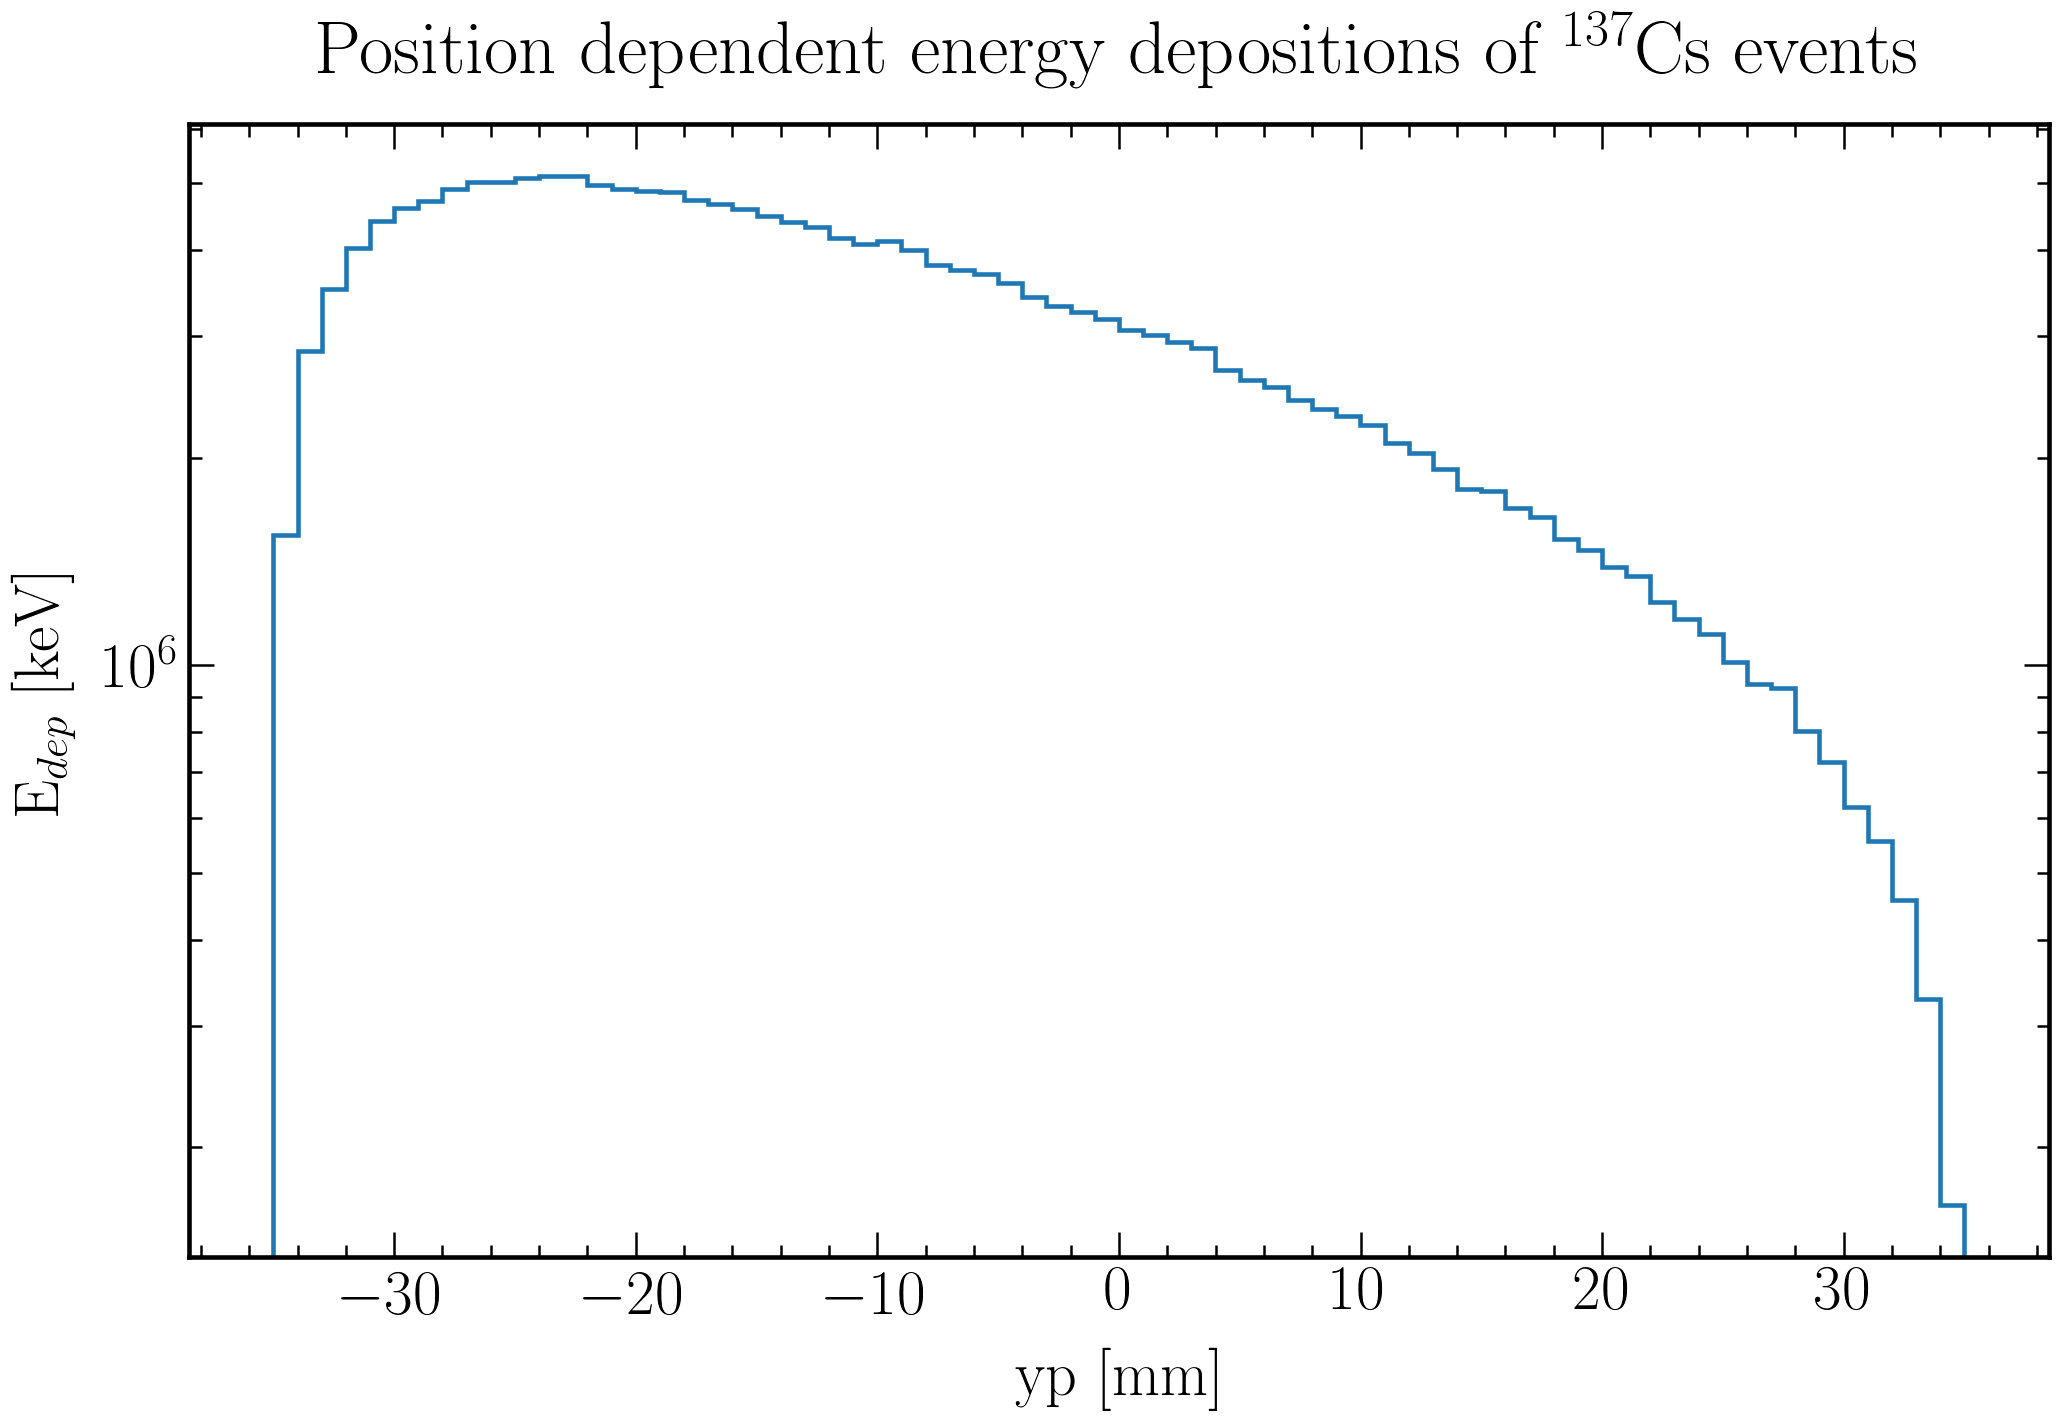

In [26]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
n, bins, patches = plt.hist(yp_flat, 70, weights = ed_flat, facecolor='darkblue', histtype = 'step', linewidth = 2.2)

plt.xlabel('yp [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('E$_{dep}$ [keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Position dependent energy depositions of $^{137}$Cs events', fontsize = title_size, pad = title_pad)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_yp_spectrum_ed-weighted.png")

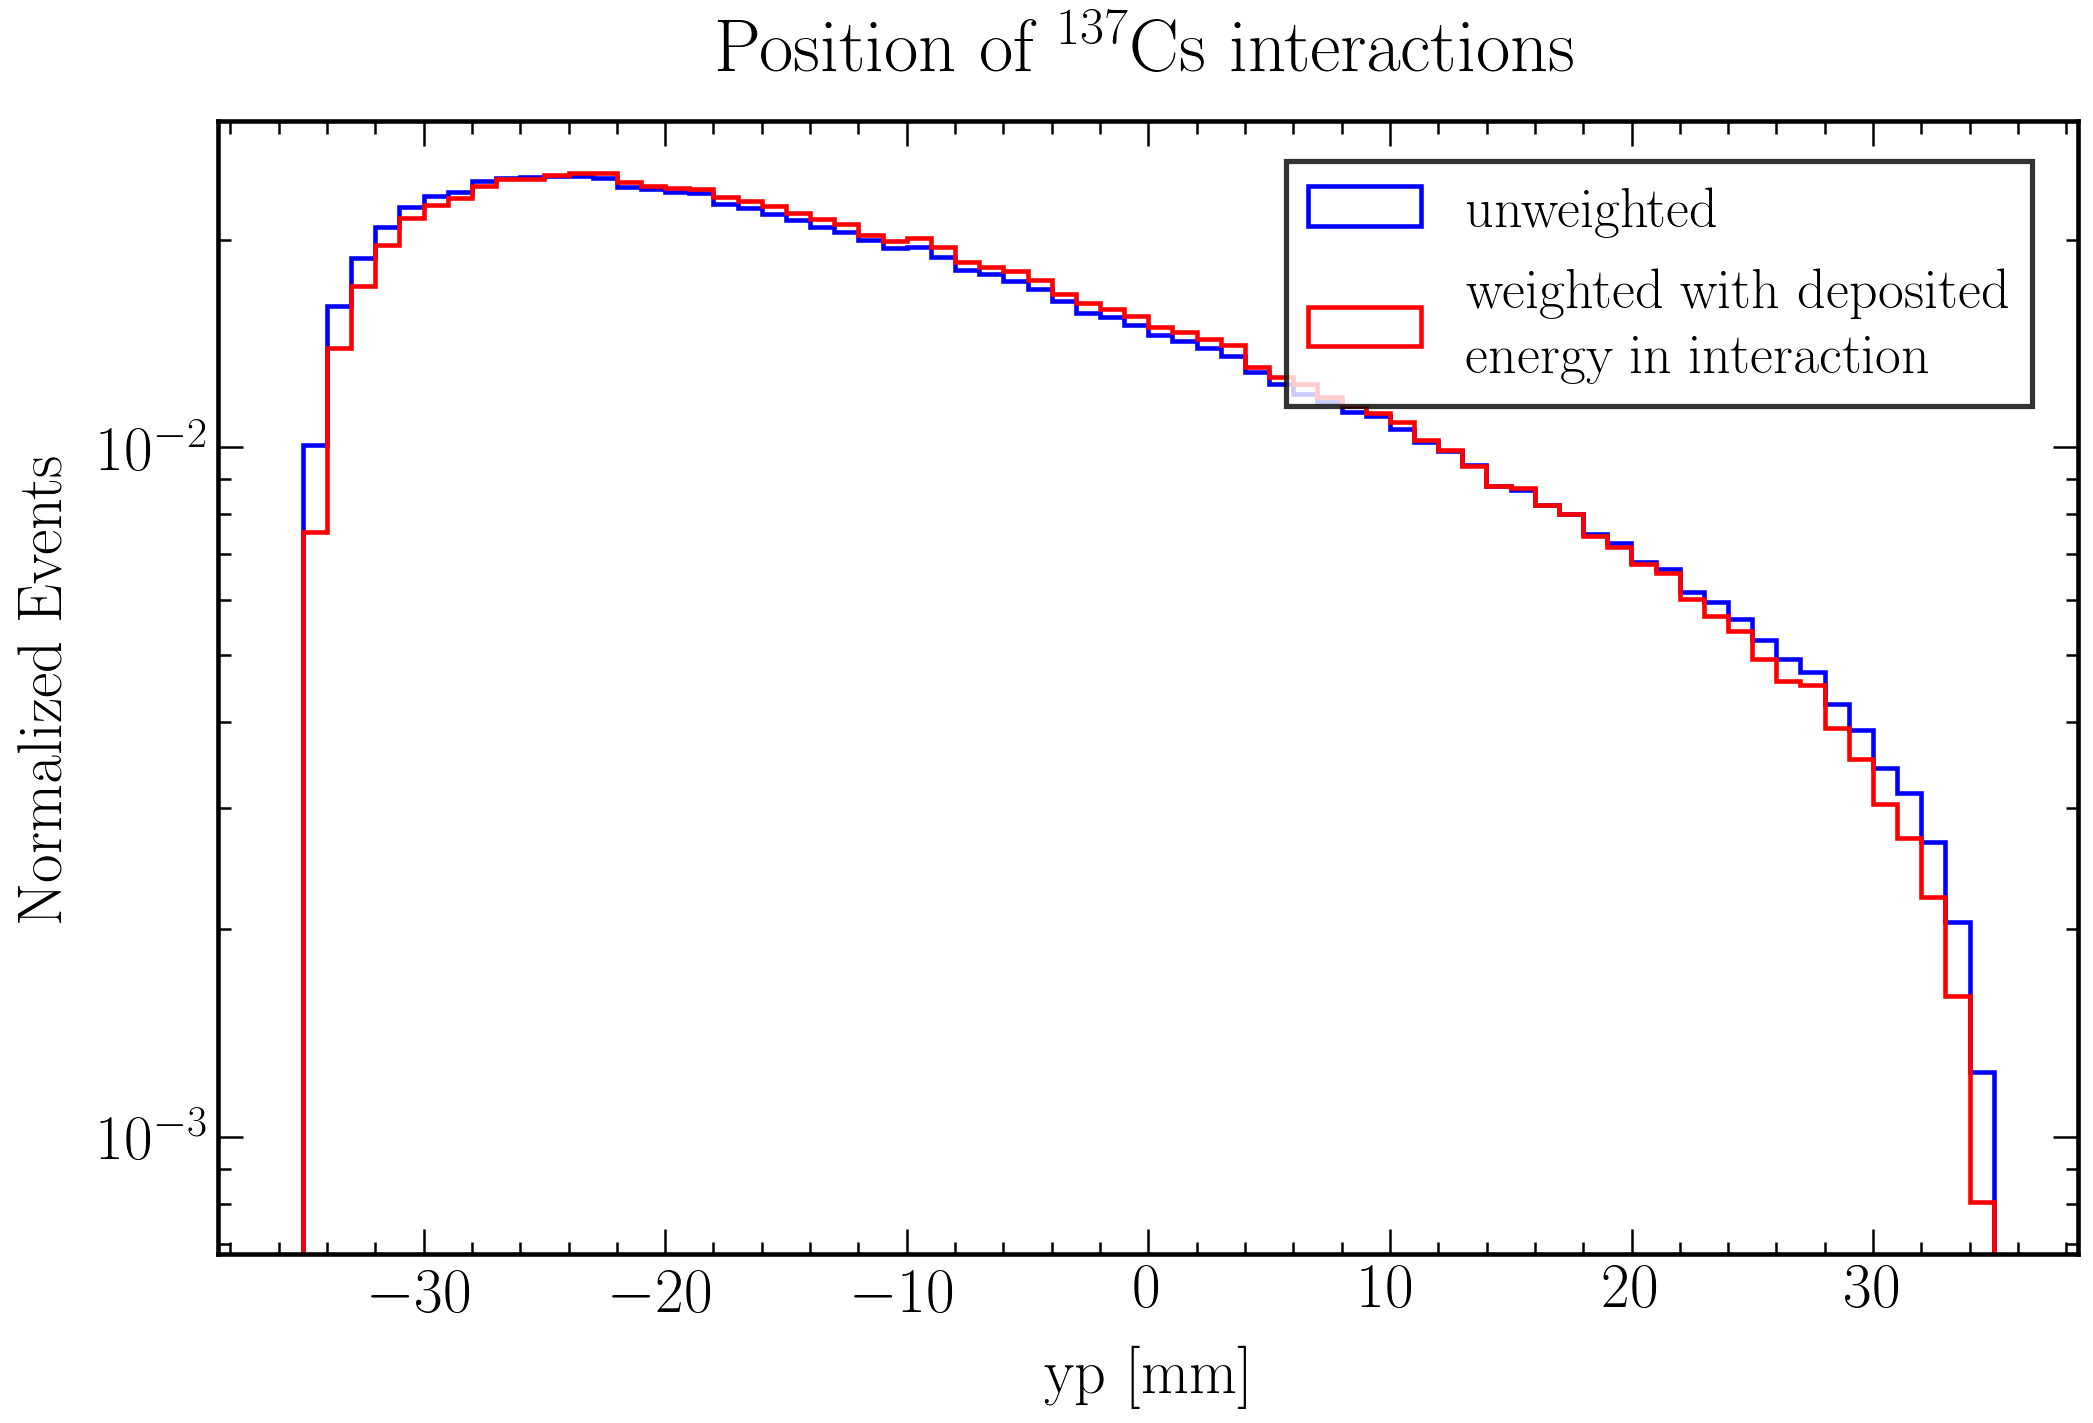

In [27]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
n, bins, patches = plt.hist(yp_flat, 70, density = True, color='blue', histtype = 'step', linewidth = 2.2, label = 'unweighted')
n, bins, patches = plt.hist(yp_flat, 70, weights = ed_flat, density = True, color='red', histtype = 'step', linewidth = 2.2, label = 'weighted with deposited\nenergy in interaction')

plt.xlabel('yp [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Normalized Events', fontsize = label_size, labelpad = label_pad)
plt.title('Position of $^{137}$Cs interactions', fontsize = title_size, pad = title_pad)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
plt.yscale('log', nonposy='clip')

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5) 

plt.show()

fig.savefig(filenameprefix+"_yp_spectrum_comparison.png")

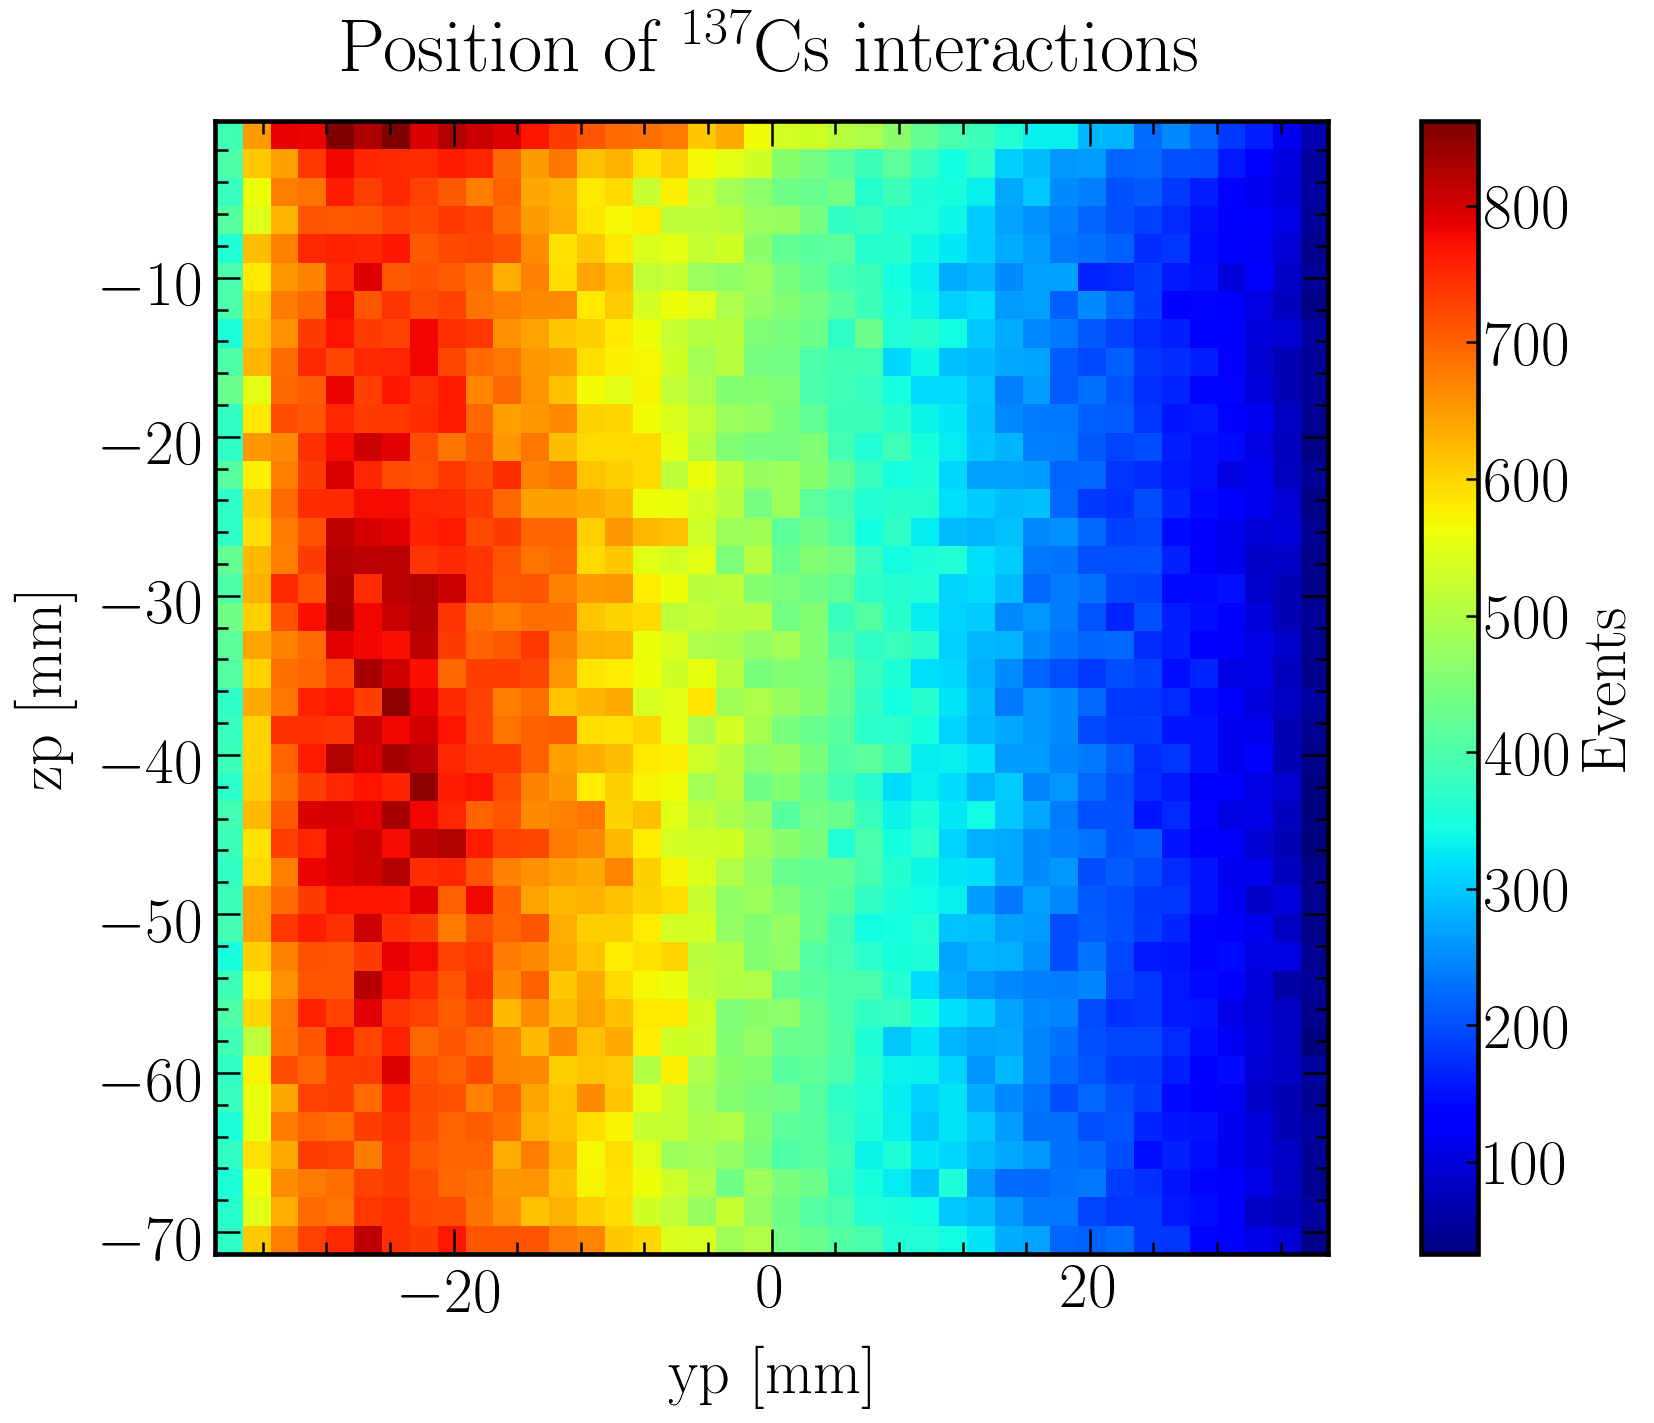

In [28]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
plt.hist2d(yp_flat, zp_flat, bins=40, cmap = 'jet')#, norm=LogNorm(), normed = True

plt.xlabel('yp [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('zp [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('Position of $^{137}$Cs interactions', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Events', fontsize=label_size) # Normalized 

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_yp_zp.png")

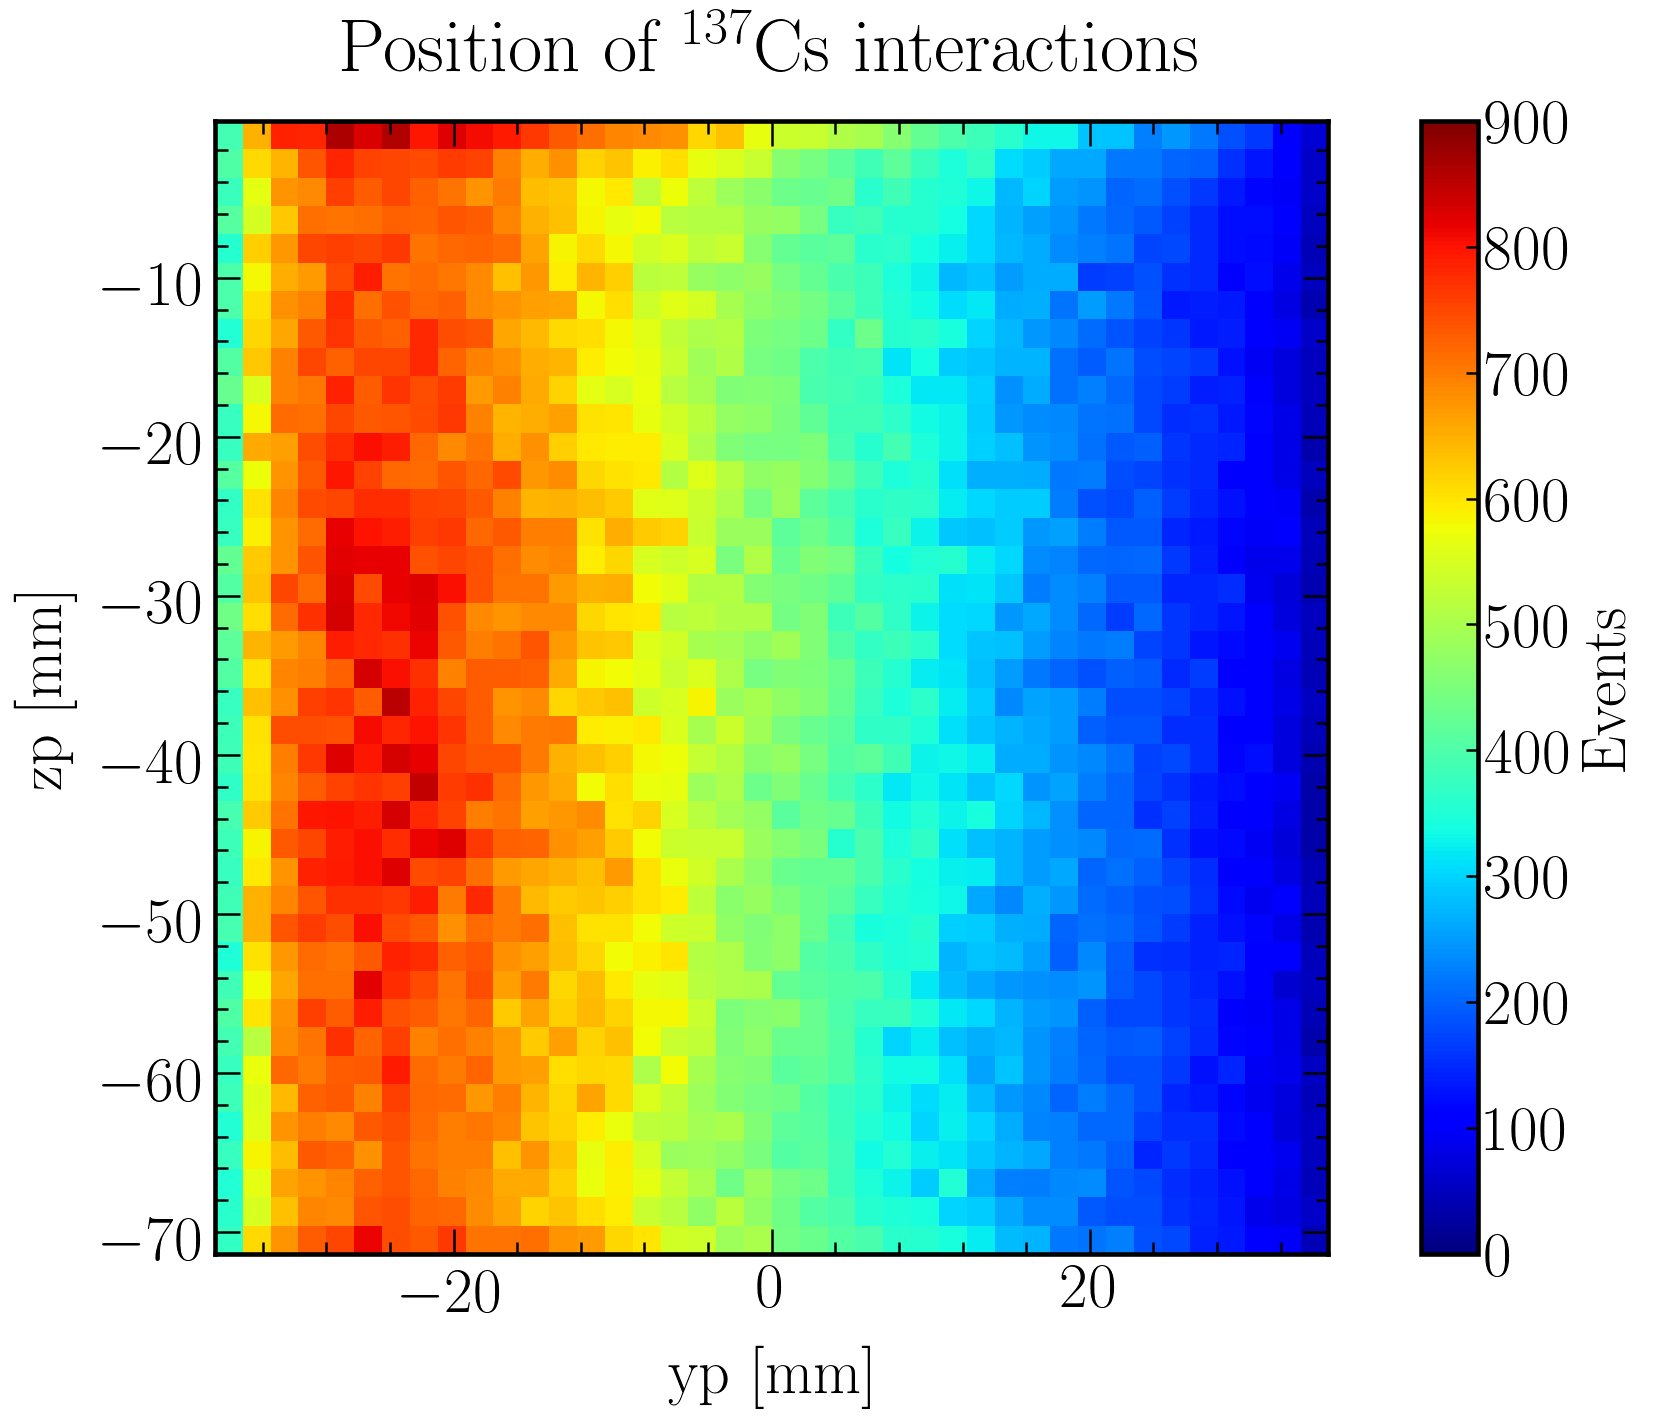

In [29]:
if Clustered == True:

    #############################################
    ## Set plot styles:
    #############################################

    fig=plt.figure(figsize=(16, 10), dpi=150)

    # Text options
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Labels
    label_size = 30 #25
    label_pad = 12 #10
    title_size = 36 #30
    title_pad = 24 #20

    # Axes Parameters
    axes = plt.gca()
    axes.tick_params(axis='both') 

    # Axes ---> Linewidth
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(2.2)

    # Axes ---> Ticks
    axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

    # Grid
    #plt.grid(True)

    #############################################
    ## Plot specific settings and plot data
    #############################################

    # Data plot
    plt.hist2d(yp_flat, zp_flat, bins=40, vmin=0, vmax=900, cmap = 'jet')#, norm=LogNorm(), normed = True

    plt.xlabel('yp [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
    plt.ylabel('zp [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
    plt.title('Position of $^{137}$Cs interactions', fontsize = title_size, pad = title_pad)

    plt.gca().set_aspect('equal', adjustable='box')

    # Colorbar
    cbar = plt.colorbar()
    cbar.outline.set_linewidth(2.2)
    cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
    cbar.set_label(label='Events', fontsize=label_size) # Normalized 

    # Axes ---> Range
    #plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
    #plt.ylim(0,16000)
    #plt.xlim(left=0)
    #plt.yscale('log', nonposy='clip')

    plt.show()

    fig.savefig(filenameprefix+"_yp_zp_scaled.png")

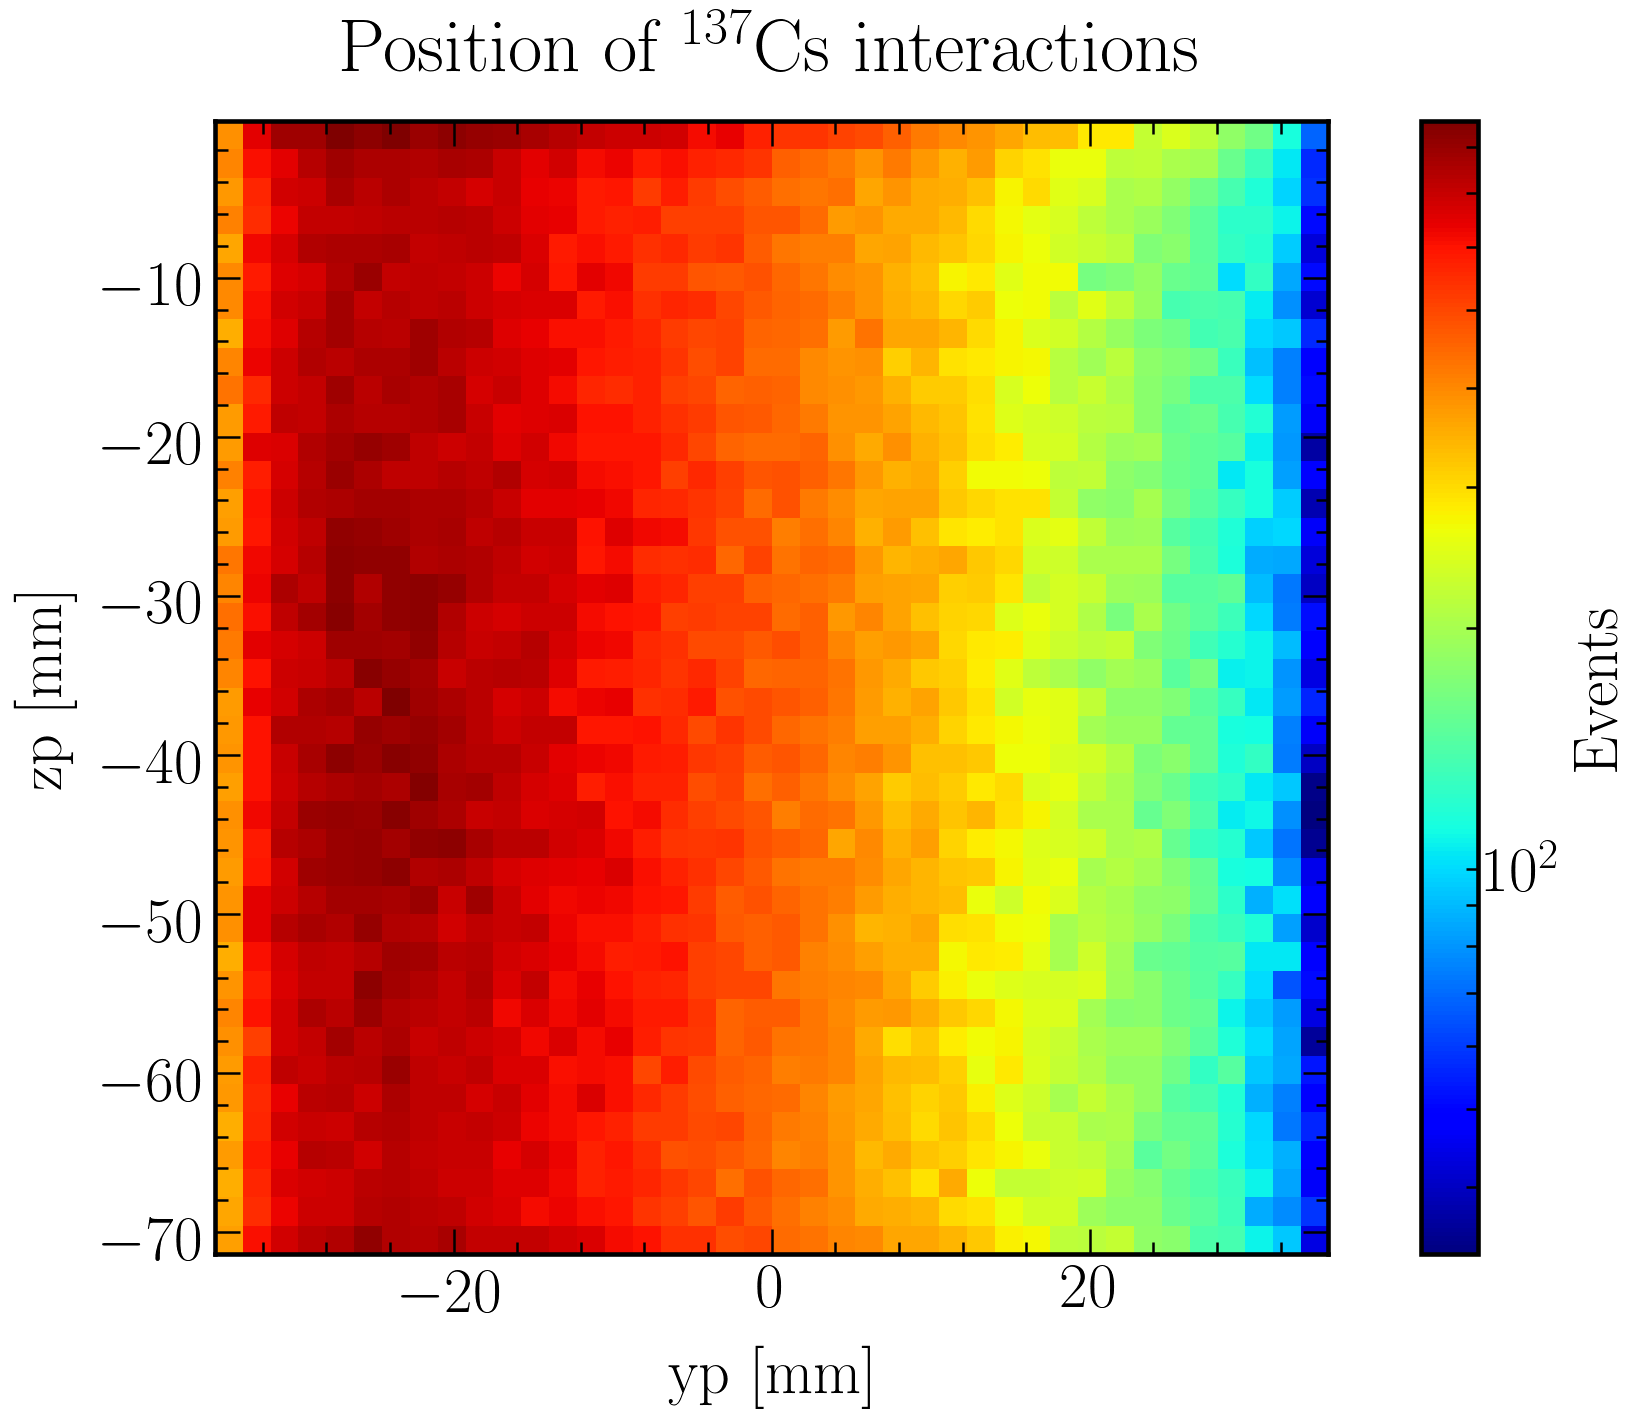

In [30]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
plt.hist2d(yp_flat, zp_flat, bins=40, cmap = 'jet', norm=LogNorm())#, normed = True

plt.xlabel('yp [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('zp [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('Position of $^{137}$Cs interactions', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Events', fontsize=label_size) # Normalized 

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_yp_zp_log.png")

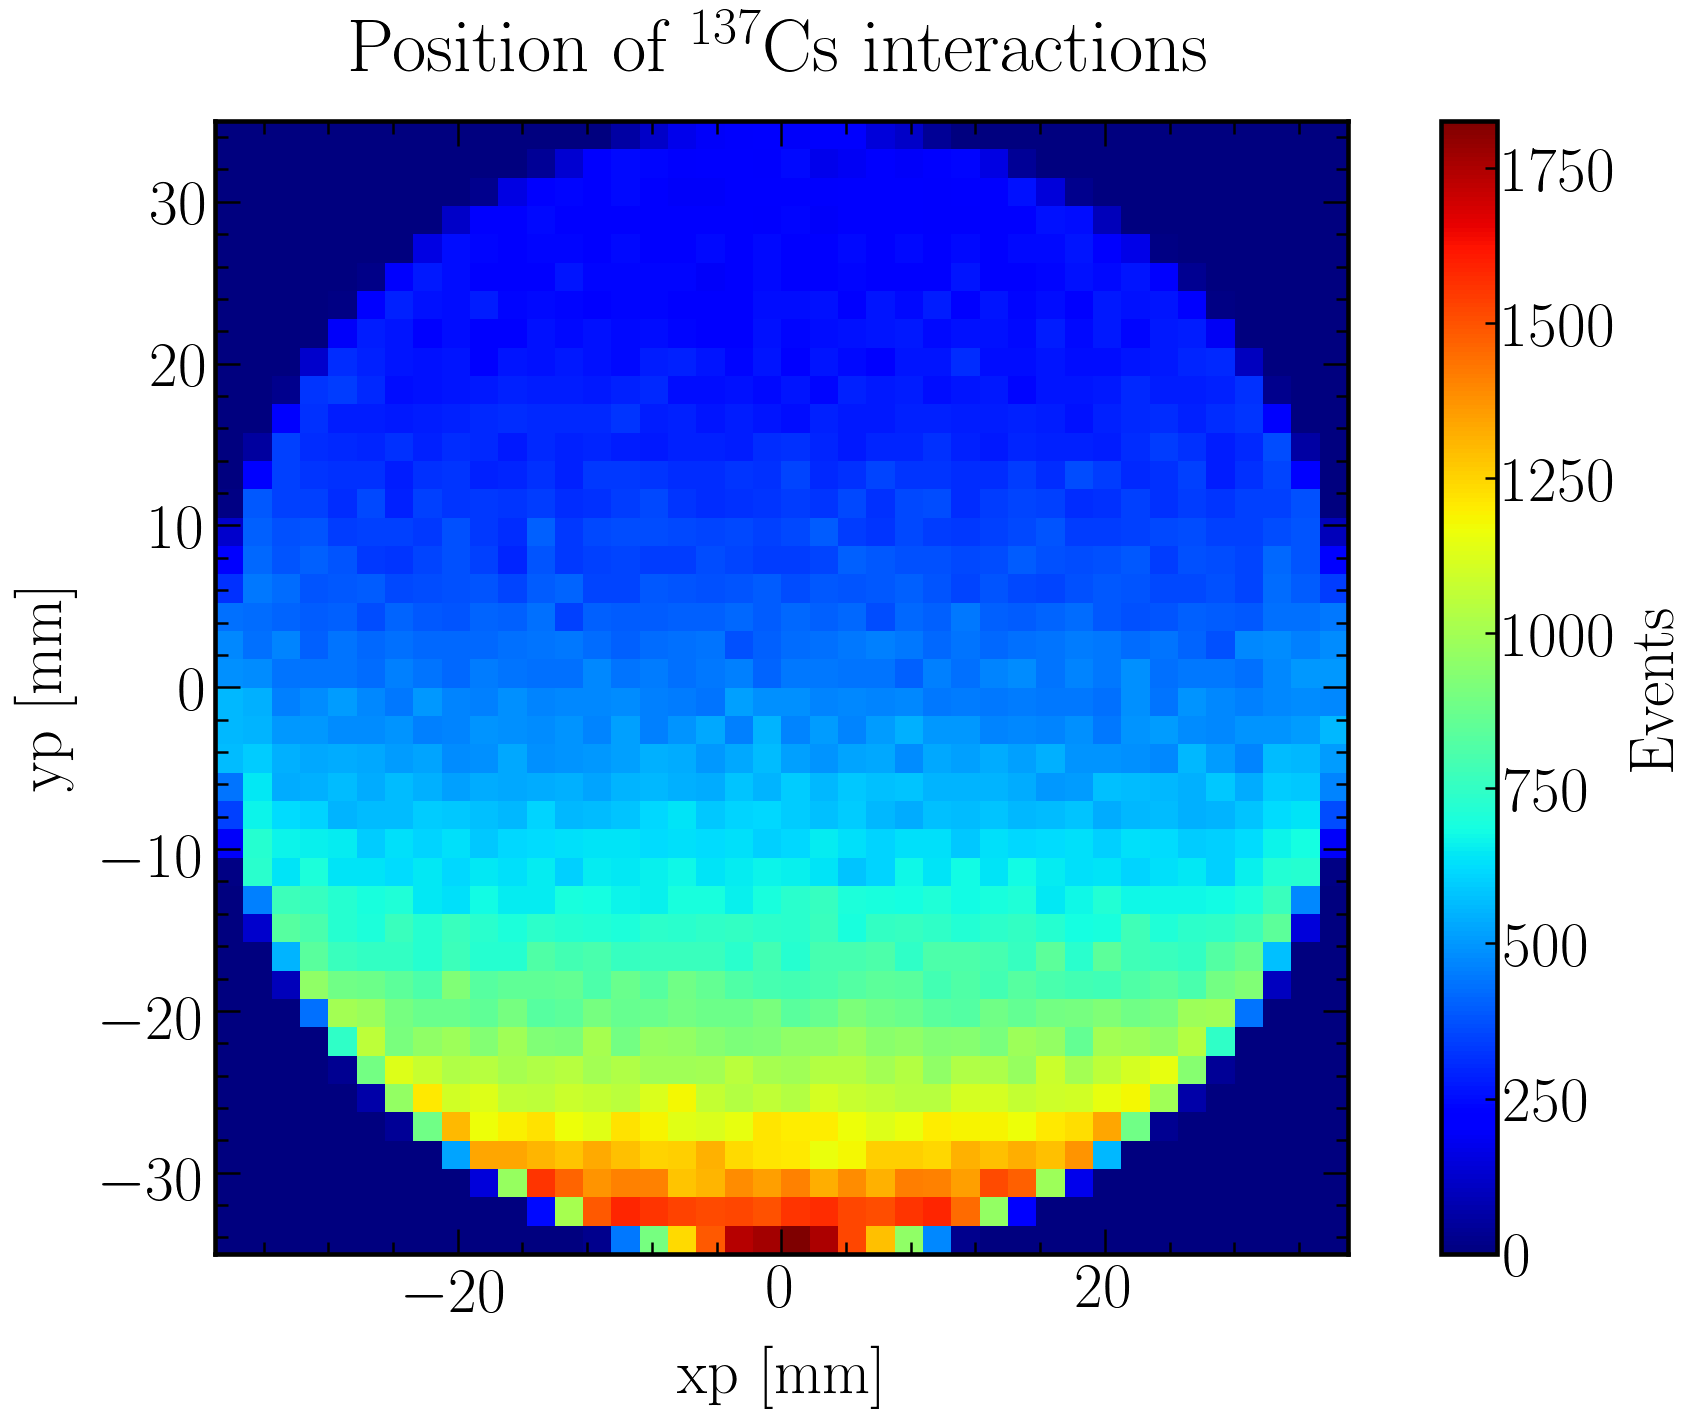

In [31]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
plt.hist2d(xp_flat, yp_flat, bins=40, cmap = 'jet')#, norm=LogNorm(), normed = True

plt.xlabel('xp [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('yp [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('Position of $^{137}$Cs interactions', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Events', fontsize=label_size) # Normalized 

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_xp_yp.png")

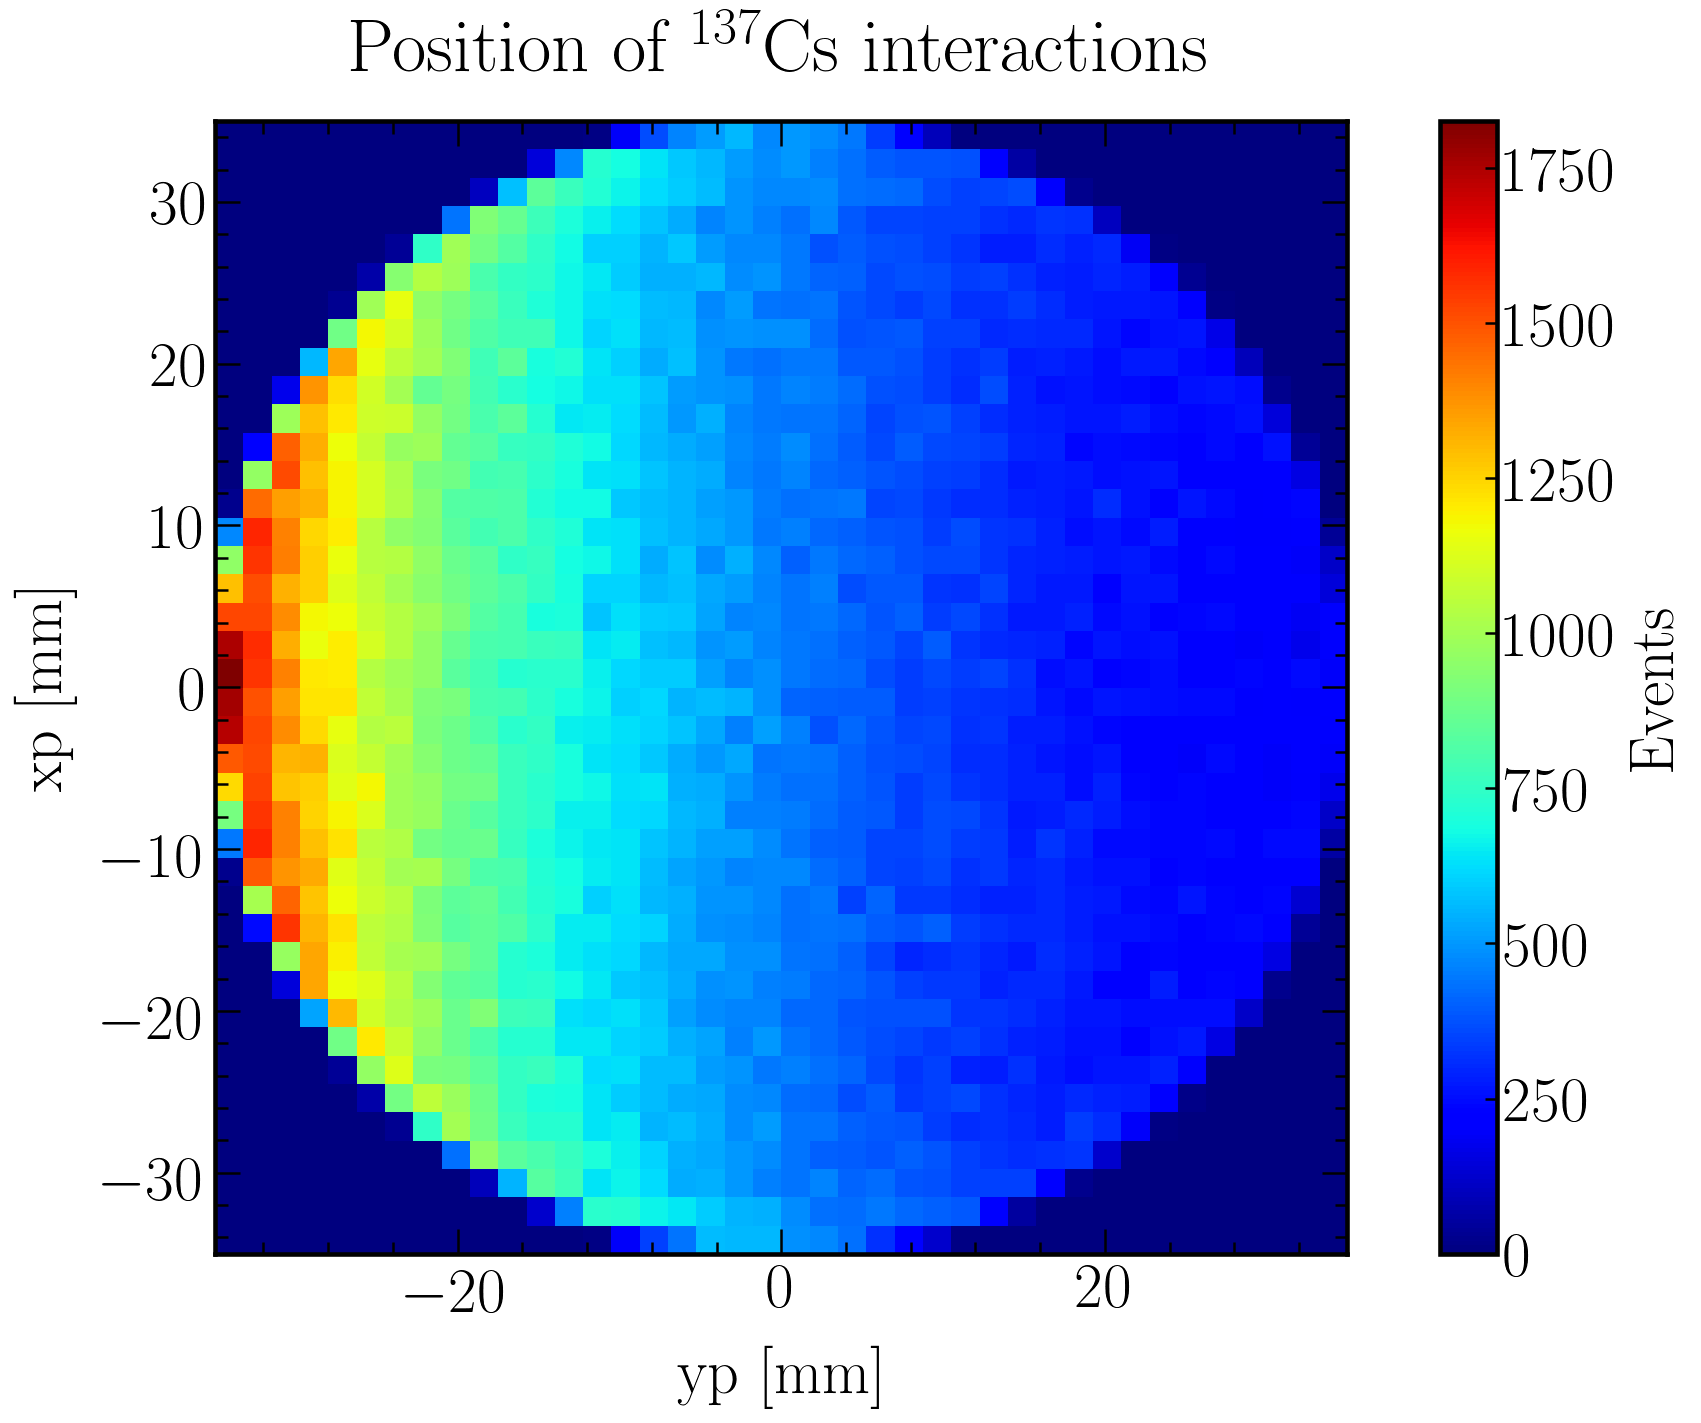

In [41]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
plt.hist2d(yp_flat, xp_flat, bins=40, cmap = 'jet')#, norm=LogNorm(), normed = True

plt.xlabel('yp [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('xp [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('Position of $^{137}$Cs interactions', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Events', fontsize=label_size) # Normalized 

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_yp_xp.png")

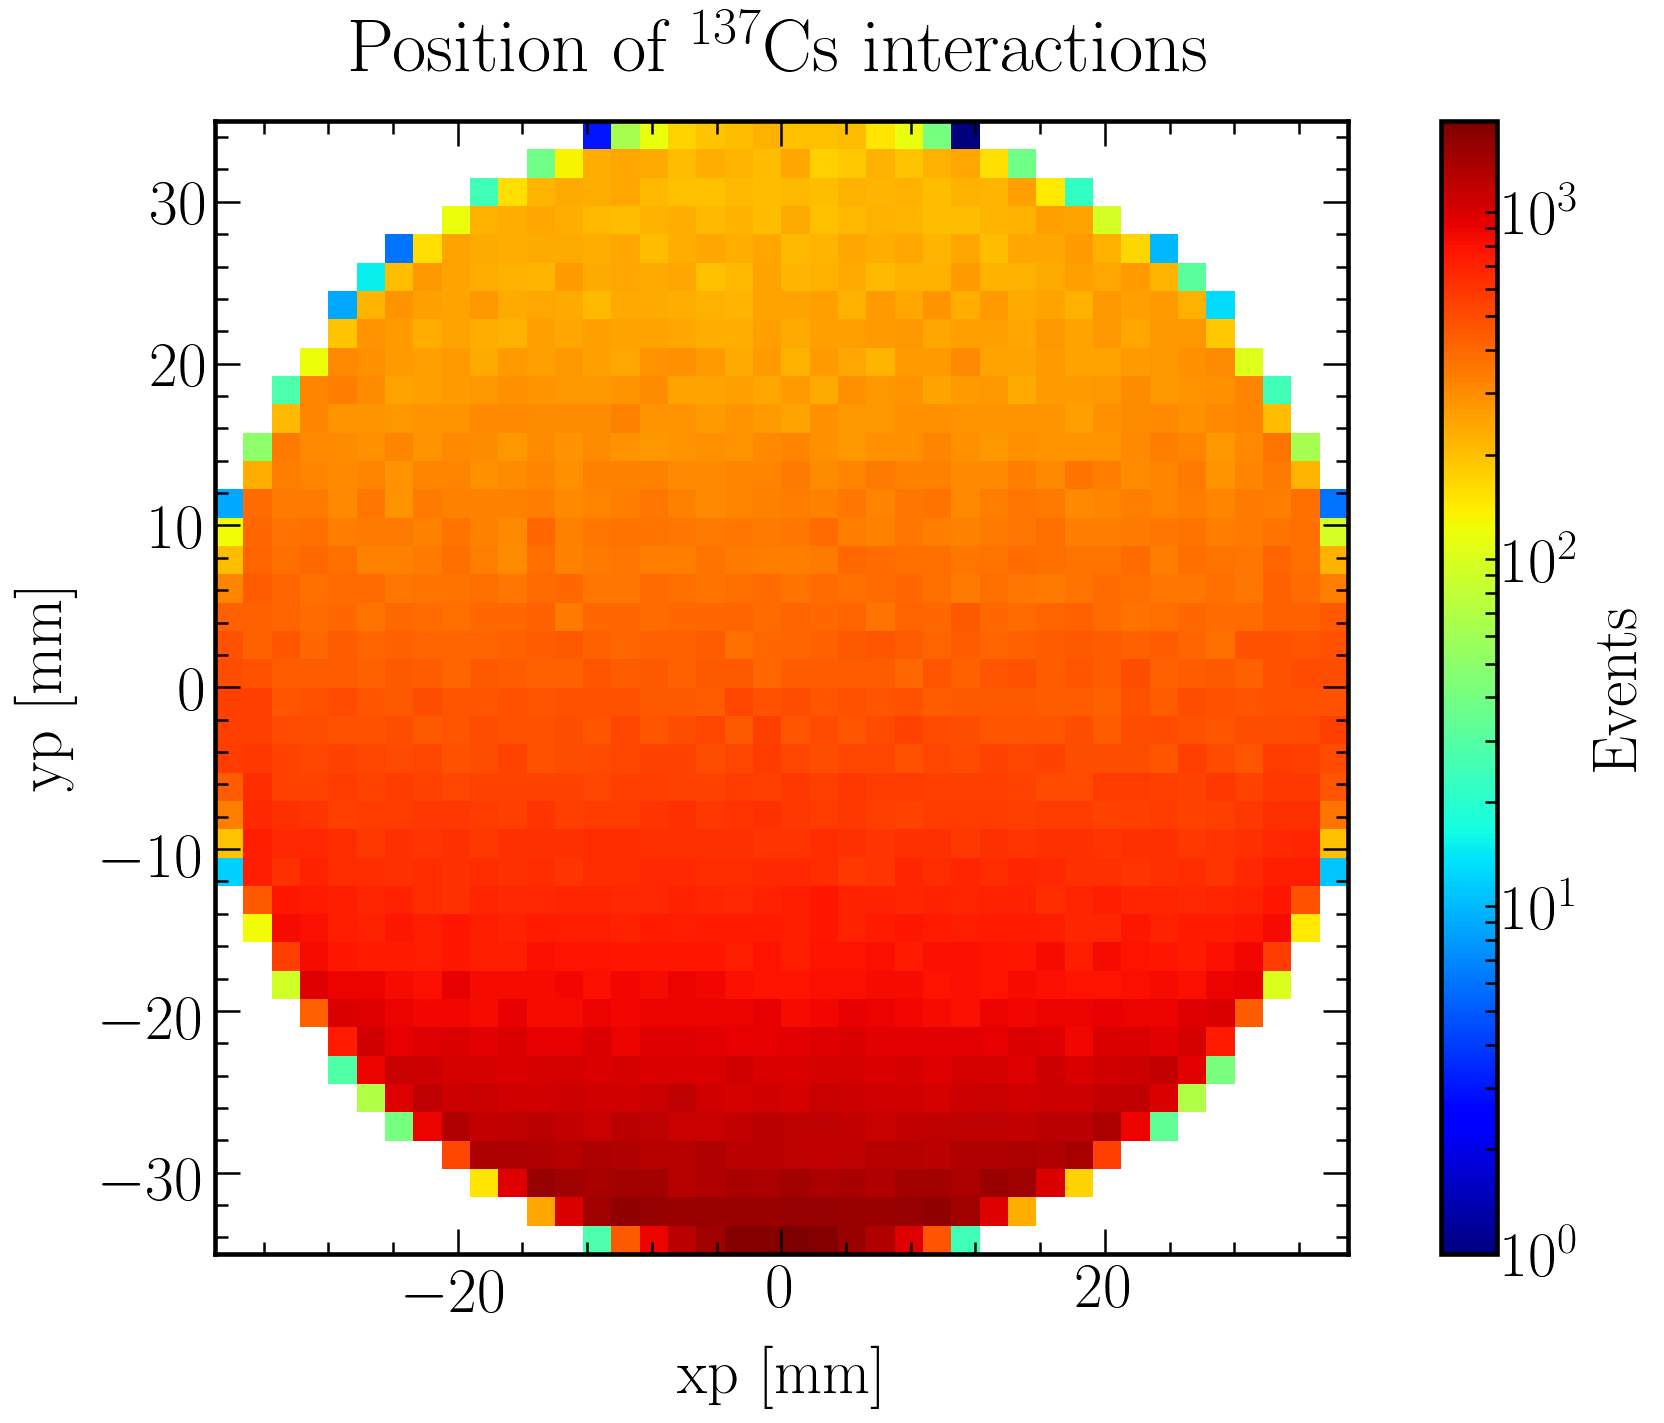

In [32]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
plt.hist2d(xp_flat, yp_flat, bins=40, cmap = 'jet', norm=LogNorm())#, normed = True

plt.xlabel('xp [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('yp [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('Position of $^{137}$Cs interactions', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Events', fontsize=label_size) # Normalized 

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_xp_yp_log.png")

### Fit y-positions

In [33]:
x_slice_width = 3.; # half width slice x in mm
#y_slice_width = np.sqrt(35. * 35. - x_slice_width * x_slice_width)
y_slice_width = 20.

crits = (yp_flat <= y_slice_width)*(yp_flat >= -y_slice_width)*(xp_flat <= x_slice_width)*(xp_flat >= -x_slice_width)

yp_flat_slice = yp_flat[crits]
xp_flat_slice = xp_flat[crits]
ed_flat_slice = xp_flat[crits]

/home/ab602/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


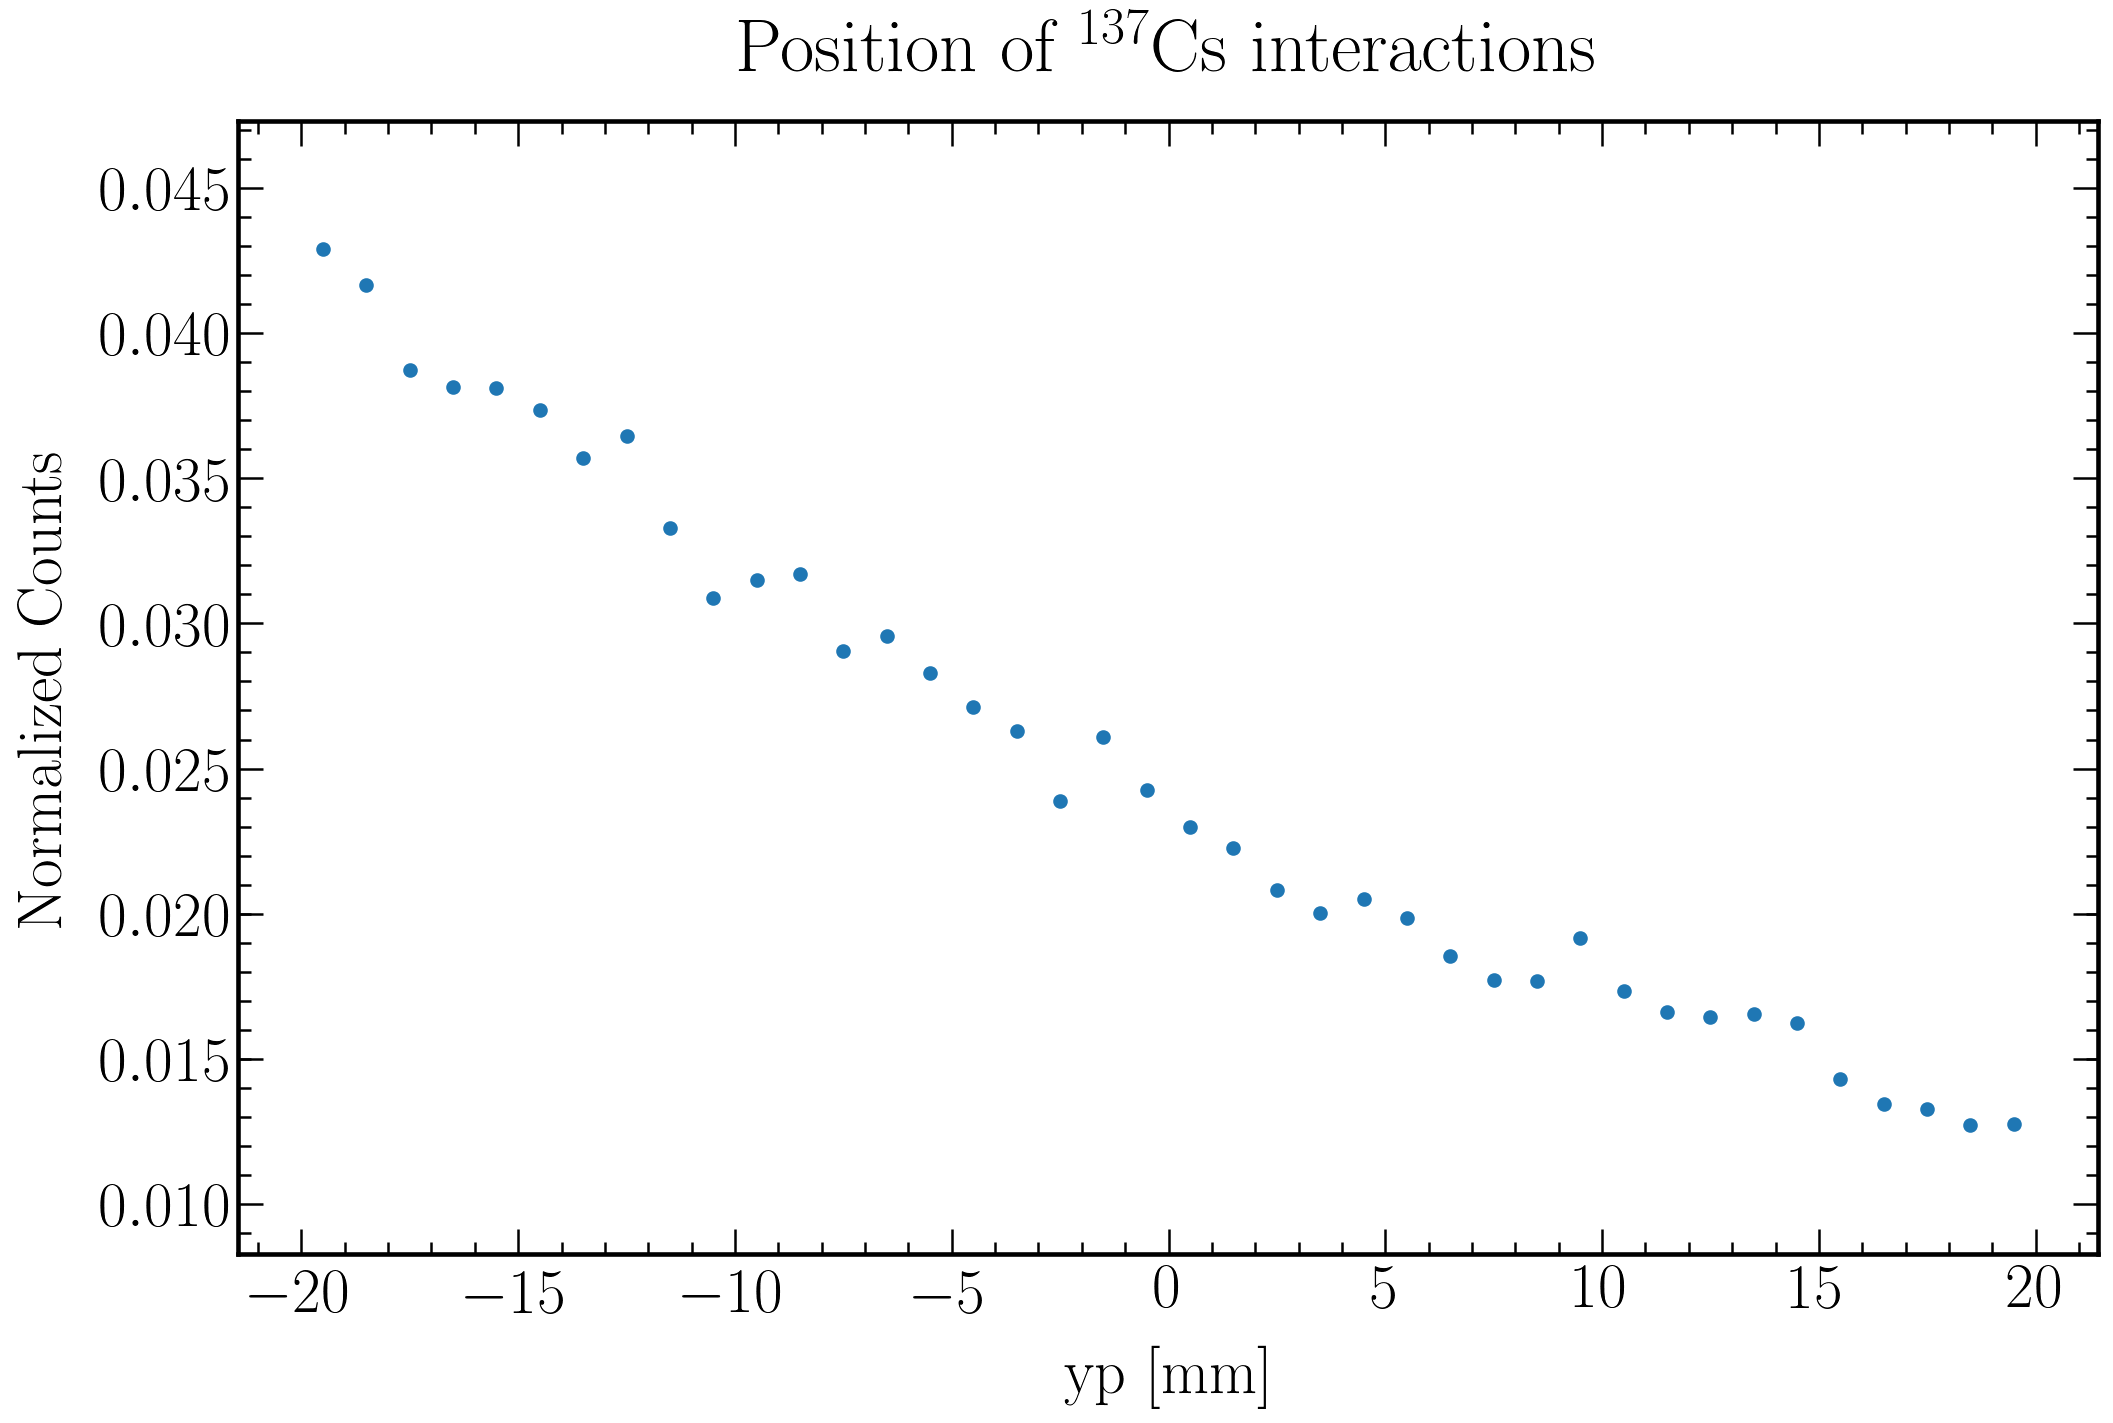

In [34]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
numberbins = 40

#n, bins, patches = plt.hist(yp_flat_slice, numberbins, facecolor='darkblue', histtype = 'step', linewidth = 2.2)

n_yp_flat_slice, bins_yp_flat_slice = np.histogram(yp_flat_slice, numberbins, density = True)
bins_center_yp_flat_slice = (bins_yp_flat_slice[:-1]+bins_yp_flat_slice[1:])/2
#plt.step(bins_center_yp_flat_slice, n_yp_flat_slice,where='mid',color='k',linestyle='--') # for normalization: /(len(yp_flat_slice)/numberbins)
plt.scatter(bins_center_yp_flat_slice, n_yp_flat_slice)

#plt.plot(bins_center_yp_flat_slice, func(bins_center_yp_flat_slice, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

plt.xlabel('yp [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Normalized Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Position of $^{137}$Cs interactions', fontsize = title_size, pad = title_pad)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_yp_spectrum_slice.png")

In [35]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

#guess = np.array([2e4, 1, 1])

popt, pcov = curve_fit(func, bins_center_yp_flat_slice, n_yp_flat_slice) # , guess
popt

/home/ab602/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


array([1., 1., 1.])

## Comparison of different files

In [36]:
## Available ROOT files in specified folder:
#! ls ../../Xebra_G4/*.root
#! ls ../../Analysis/Calibration_simulations_pointsource/data
! ls ../../Simulation_Data/Calibration_simulations_pointsource/*.root

../../Simulation_Data/Calibration_simulations_pointsource/Cs137_1e5_noscint.root
../../Simulation_Data/Calibration_simulations_pointsource/Cs137_1e5_scint.root
../../Simulation_Data/Calibration_simulations_pointsource/Cs137_1e6_noscint_inside.root
../../Simulation_Data/Calibration_simulations_pointsource/Cs137_1e7_noscint.root
../../Simulation_Data/Calibration_simulations_pointsource/Cs137_1e8_noscint.root


### Scintillation - no scintillation

In [37]:
'''## File 1

filename1 = '../../Simulation_Data/Calibration_simulations_pointsource/Cs137_1e5_noscint.root'

branches= ['xp_pri','yp_pri','zp_pri','xp','yp','zp','etot','ed','nsteps'] # Be careful that the branches are also initilized in _chunk_collect

import concurrent.futures
executor = concurrent.futures.ThreadPoolExecutor(8)

_chunk_collect = pd.DataFrame({'xp_pri' : [],'yp_pri' : [],'zp_pri' : [], 'xp' : [],'yp' : [],'zp' : [],'etot' : [],'ed' : [],'nsteps' : []}) # Initialize empty data frame

for _chunk in uproot.iterate(filename1, "events/events",branches, entrysteps=100000, 
                                       outputtype=pd.DataFrame, executor=executor):
    _chunk.columns=branches
    _chunk_collect = _chunk_collect.append(_chunk)
    
xp_pri1 = _chunk_collect.xp_pri
yp_pri1 = _chunk_collect.yp_pri
zp_pri1 = _chunk_collect.zp_pri
nevents1 = len(xp_pri1)
xp1 = _chunk_collect.xp
yp1 = _chunk_collect.yp
zp1 = _chunk_collect.zp
etot1 = _chunk_collect.etot
ed1 = _chunk_collect.ed
nsteps1 = _chunk_collect.nsteps

xp_flat1 = flatten_tuples(xp1)
yp_flat1 = flatten_tuples(yp1)
zp_flat1 = flatten_tuples(zp1)
rp_flat1 = np.sqrt(xp_flat1 * xp_flat1 + yp_flat1 * yp_flat1)
ed_flat1 = flatten_tuples(ed1)

try:
    del _chunk
    print("Deleted _chunk")
except NameError:
    print("Deleted _chunk (already done)")
    
try:
    del _chunk_collect
    print("Deleted _chunk_collect")
except NameError:
    print("Deleted _chunk_collect (already done)")''';

In [38]:
'''## File 1

filename2 = '../../Simulation_Data/Calibration_simulations_pointsource/Cs137_1e5_scint.root'

branches= ['xp_pri','yp_pri','zp_pri','xp','yp','zp','etot','ed','nsteps'] # Be careful that the branches are also initilized in _chunk_collect

import concurrent.futures
executor = concurrent.futures.ThreadPoolExecutor(8)

_chunk_collect = pd.DataFrame({'xp_pri' : [],'yp_pri' : [],'zp_pri' : [], 'xp' : [],'yp' : [],'zp' : [],'etot' : [],'ed' : [],'nsteps' : []}) # Initialize empty data frame

for _chunk in uproot.iterate(filename2, "events/events",branches, entrysteps=100000, 
                                       outputtype=pd.DataFrame, executor=executor):
    _chunk.columns=branches
    _chunk_collect = _chunk_collect.append(_chunk)
    
xp_pri2 = _chunk_collect.xp_pri
yp_pri2 = _chunk_collect.yp_pri
zp_pri2 = _chunk_collect.zp_pri
nevents2 = len(xp_pri2)
xp2 = _chunk_collect.xp
yp2 = _chunk_collect.yp
zp2 = _chunk_collect.zp
etot2 = _chunk_collect.etot
ed2 = _chunk_collect.ed
nsteps2 = _chunk_collect.nsteps

xp_flat2 = flatten_tuples(xp2)
yp_flat2 = flatten_tuples(yp2)
zp_flat2 = flatten_tuples(zp2)
rp_flat2 = np.sqrt(xp_flat2 * xp_flat2 + yp_flat2 * yp_flat2)
ed_flat2 = flatten_tuples(ed2)

try:
    del _chunk
    print("Deleted _chunk")
except NameError:
    print("Deleted _chunk (already done)")
    
try:
    del _chunk_collect
    print("Deleted _chunk_collect")
except NameError:
    print("Deleted _chunk_collect (already done)")''';

In [39]:
'''#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
n, bins, patches = plt.hist(etot1, 35, color='darkblue', histtype = 'step', linewidth = 2.2, label = 'no scintillation')# , density = True
n, bins, patches = plt.hist(etot2, 35, color='red', histtype = 'step', linewidth = 2.2, label = 'scintillation', linestyle = '--')# , density = True


plt.xlabel('E [keV]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad) # Normalized 
plt.title('Simulated $^{137}$Cs spectrum from total deposited energy', fontsize = title_size, pad = title_pad)

# Axes ---> Shading an area or Drawing a vertica line
#axes.axvspan(662-10, 662+10, alpha=0.5, color='0.8')
#plt.axvline(662, alpha=0.5, color='grey')

# Axes ---> Range
plt.xlim(0,700)
#plt.ylim(0,16000)
#plt.xlim(left=0)
plt.yscale('log', nonposy='clip')

leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5) 

plt.show()

fig.savefig("Cs137_1e5_totalenergy_spectrum_comparison_scint.png")''';

In [40]:
'''#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
n, bins, patches = plt.hist(yp_flat1, 35, color='darkblue', histtype = 'step', linewidth = 2.2, density = True, label = 'no scintillation')
n, bins, patches = plt.hist(yp_flat2, 35, color='red', histtype = 'step', linewidth = 2.2, density = True, label = 'scintillation', linestyle = '--')


plt.xlabel('yp [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Normalized Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Position of $^{137}$Cs interactions', fontsize = title_size, pad = title_pad)

# Axes ---> Shading an area or Drawing a vertica line
#axes.axvspan(662-10, 662+10, alpha=0.5, color='0.8')
#plt.axvline(662, alpha=0.5, color='grey')

# Axes ---> Range
#plt.xlim(0,700)
#plt.ylim(0,16000)
#plt.xlim(left=0)
plt.yscale('log', nonposy='clip')

leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5) 

plt.show()

fig.savefig("Cs137_1e5_yp_spectrum_comparison_scint.png")''';